In [336]:
# libraries
RANDOM_STATE = 233

# basic analysis & viz
import numpy as np
np.random.seed(RANDOM_STATE)

import pandas as pd
import seaborn as sns
import missingno as msn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# plt.style.use('ggplot')
sns.set_style('darkgrid', {'grid.background': 'blue'})

# statistics
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats

# from sklearn.datasets import load_boston
# from fairlearn.datasets import fetch_boston

# split & metrics
from sklearn.model_selection import (
    cross_validate, cross_val_score,
    GridSearchCV, KFold, RandomizedSearchCV, 
    train_test_split, StratifiedKFold 
)
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    mean_absolute_percentage_error, make_scorer,
    root_mean_squared_error, PredictionErrorDisplay
)
from sklearn.metrics._scorer import _SCORERS

# preprocessing
# import smogn
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.preprocessing import (
    OneHotEncoder, KBinsDiscretizer, MinMaxScaler,
    OrdinalEncoder, RobustScaler, StandardScaler,
    PolynomialFeatures, 
)
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import RFE, RFECV

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
from category_encoders import BinaryEncoder

# models
import shap
shap.initjs()

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import (
    LinearRegression, Lasso, Ridge,
    HuberRegressor, TheilSenRegressor,
    QuantileRegressor, RANSACRegressor
)

from sklearn.ensemble import (
    AdaBoostRegressor, GradientBoostingRegressor,
    VotingRegressor, RandomForestRegressor
)
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor

# others
import os
import sys
import time
import pickle
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

import random

In [337]:
df_all = pd.read_csv(r'C:\Users\ivans\Desktop\FINAL PROJECT\Dataset\AutoInsurance.csv')
df_all.head(5)

Customer       State  Customer Lifetime Value Response  Coverage Education  \
0  BU79786  Washington              2763.519279       No     Basic  Bachelor   
1  QZ44356     Arizona              6979.535903       No  Extended  Bachelor   
2  AI49188      Nevada             12887.431650       No   Premium  Bachelor   
3  WW63253  California              7645.861827       No     Basic  Bachelor   
4  HB64268  Washington              2813.692575       No     Basic  Bachelor   

  Effective To Date EmploymentStatus Gender  Income Location Code  \
0           2/24/11         Employed      F   56274      Suburban   
1           1/31/11       Unemployed      F       0      Suburban   
2           2/19/11         Employed      F   48767      Suburban   
3           1/20/11       Unemployed      M       0      Suburban   
4          3/2/2011         Employed      M   43836         Rural   

  Marital Status  Monthly Premium Auto  Months Since Last Claim  \
0        Married                    69                       32   
1         Single                    94                       13   
2        Married                   108                       18   
3        Married                   106                       18   
4         Single                    73                       12   

   Months Since Policy Inception  Number of Open Complaints  \
0                              5                          0   
1                             42                          0   
2                             38                          0   
3                             65                          0   
4                             44                          0   

   Number of Policies     Policy Type        Policy Renew Offer Type  \
0                   1  Corporate Auto  Corporate L3           Offer1   
1                   8   Personal Auto   Personal L3           Offer3   
2                   2   Personal Auto   Personal L3           Offer1   
3                   7  Corporate Auto  Corporate L2           Offer1   
4                   1   Personal Auto   Personal L1           Offer1   

  Sales Channel  Total Claim Amount  Vehicle Class Vehicle Size  
0         Agent          384.811147   Two-Door Car      Medsize  
1         Agent         1131.464935  Four-Door Car      Medsize  
2         Agent          566.472247   Two-Door Car      Medsize  
3   Call Center          529.881344            SUV      Medsize  
4         Agent          138.130879  Four-Door Car      Medsize

# SPLIT DATASET FOR DATATEST

In [338]:
# Features and target variable
X = df_all.drop(columns=['Customer Lifetime Value'])
y = df_all['Customer Lifetime Value']

# Split the data without stratification (since 'Customer Lifetime Value' is continuous)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Combine the training and test sets with the target variable
df = X_train
df['Customer Lifetime Value'] = y_train
df.to_csv('new_dataset.csv', index=False)

test_data = X_test.copy()
test_data['Customer Lifetime Value'] = y_test

# Save the test set to a CSV file
test_data.to_csv('test_data_finpro.csv', index=False)

print("Test data saved to 'test_data_finpro.csv")
print("Shape of the training data:", df.shape)
print("Shape of the real test set data:", test_data.shape)

Test data saved to 'test_data_finpro.csv'
Shape of the training data: (7307, 24)
Shape of the real test set data: (1827, 24)


In [339]:
df = pd.read_csv(r'C:\Users\ivans\Desktop\FINAL PROJECT\Code\New_dataset.csv')
df.head(5)

Customer       State Response  Coverage Education Effective To Date  \
0  YQ79307  Washington       No     Basic  Bachelor         10/1/2011   
1  CY49953      Oregon       No  Extended   College           2/18/11   
2  XN16891     Arizona       No     Basic   College           2/28/11   
3  EP64069  California       No     Basic  Bachelor          8/1/2011   
4  IW77519  Washington       No     Basic  Bachelor           1/18/11   

  EmploymentStatus Gender  Income Location Code Marital Status  \
0         Employed      M   51144         Urban        Married   
1       Unemployed      F       0      Suburban         Single   
2         Employed      M   81097      Suburban       Divorced   
3         Employed      F   72264         Urban        Married   
4         Employed      F   54737      Suburban         Single   

   Monthly Premium Auto  Months Since Last Claim  \
0                    61                       28   
1                    79                       30   
2                    74                        7   
3                    64                        2   
4                    66                        3   

   Months Since Policy Inception  Number of Open Complaints  \
0                             32                          1   
1                             25                          0   
2                             67                          0   
3                             66                          0   
4                             86                          0   

   Number of Policies     Policy Type        Policy Renew Offer Type  \
0                   9   Personal Auto   Personal L3           Offer1   
1                   1    Special Auto    Special L2           Offer3   
2                   1   Personal Auto   Personal L1           Offer4   
3                   9  Corporate Auto  Corporate L3           Offer3   
4                   1   Personal Auto   Personal L3           Offer3   

  Sales Channel  Total Claim Amount  Vehicle Class Vehicle Size  \
0         Agent          223.305224   Two-Door Car      Medsize   
1        Branch          568.800000  Four-Door Car      Medsize   
2         Agent          355.200000  Four-Door Car        Small   
3           Web          272.649844  Four-Door Car      Medsize   
4           Web          391.970334  Four-Door Car      Medsize   

   Customer Lifetime Value  
0              4768.955924  
1              2827.559570  
2              2912.892035  
3              5138.244998  
4              2610.369217

## DATA CLEANING & HANDLING THE ANOMALY

## Check data type, nullity, negative value, multiple whitespace, number of unique

In [340]:
multiple_spaces = [
    any(pd.Series(df[col]).astype(str).str.contains(r'\s{2,}', regex=True)) 
    for col in df.columns
]

# Create the summary DataFrame
summary_df = pd.DataFrame({
    'feature': df.columns.values,
    'data_type': df.dtypes.values,
    'null': df.isna().mean().values * 100,
    'negative': [True if df[col].dtype in [np.int64, np.float64] and (df[col] < 0).any() else False for col in df.columns],
    'multiple_spaces': multiple_spaces,
    'n_unique': df.nunique().values,
    'sample_unique': [df[col].unique() for col in df.columns]
    
})

# Display the summary DataFrame
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
summary_df

feature data_type  null  negative  multiple_spaces  \
0                        Customer    object   0.0     False            False   
1                           State    object   0.0     False            False   
2                        Response    object   0.0     False            False   
3                        Coverage    object   0.0     False            False   
4                       Education    object   0.0     False            False   
5               Effective To Date    object   0.0     False            False   
6                EmploymentStatus    object   0.0     False            False   
7                          Gender    object   0.0     False            False   
8                          Income     int64   0.0     False            False   
9                   Location Code    object   0.0     False            False   
10                 Marital Status    object   0.0     False            False   
11           Monthly Premium Auto     int64   0.0     False            False   
12        Months Since Last Claim     int64   0.0     False            False   
13  Months Since Policy Inception     int64   0.0     False            False   
14      Number of Open Complaints     int64   0.0     False            False   
15             Number of Policies     int64   0.0     False            False   
16                    Policy Type    object   0.0     False            False   
17                         Policy    object   0.0     False            False   
18               Renew Offer Type    object   0.0     False            False   
19                  Sales Channel    object   0.0     False            False   
20             Total Claim Amount   float64   0.0     False            False   
21                  Vehicle Class    object   0.0     False            False   
22                   Vehicle Size    object   0.0     False            False   
23        Customer Lifetime Value   float64   0.0     False            False   

    n_unique  \
0       7307   
1          5   
2          2   
3          3   
4          5   
5         59   
6          5   
7          2   
8       4652   
9          3   
10         3   
11       196   
12        36   
13       100   
14         6   
15         9   
16         3   
17         9   
18         4   
19         4   
20      4129   
21         6   
22         3   
23      6481   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   sample_unique  
0                                                                                                                                                                                                                                                                                                                                    

- Data type                 : Effective to date should be in datetime type not in object, we should change it
- null                      : There is no null value
- negative                  : There is no negative value
- multiple whitespaces      : There is no multiple whitespaces
- unique                    : Customer observation has totally unique we should drop it 
- inconsistent data         : Column Effective To Date has inconsistent data at year then we should change it

In [341]:
# Function to manually change the year from 2011 to 11
def change_year(date_str):
    if '2011' in date_str:
        return date_str.replace('2011', '11')
    return date_str

# Apply the function to the column
df['Effective To Date'] = df['Effective To Date'].apply(change_year)

### Handling Datatype

In [342]:
df['Effective To Date'] = pd.to_datetime(df['Effective To Date'], format='%m/%d/%y', errors='coerce')
df.dtypes

Customer                                 object
State                                    object
Response                                 object
Coverage                                 object
Education                                object
Effective To Date                datetime64[ns]
EmploymentStatus                         object
Gender                                   object
Income                                    int64
Location Code                            object
Marital Status                           object
Monthly Premium Auto                      int64
Months Since Last Claim                   int64
Months Since Policy Inception             int64
Number of Open Complaints                 int64
Number of Policies                        int64
Policy Type                              object
Policy                                   object
Renew Offer Type                         object
Sales Channel                            object
Total Claim Amount                      

In [343]:
df["Effective To Date"]

0      2011-10-01
1      2011-02-18
2      2011-02-28
3      2011-08-01
4      2011-01-18
          ...    
7302   2011-01-29
7303   2011-05-02
7304   2011-01-27
7305   2011-02-27
7306   2011-01-27
Name: Effective To Date, Length: 7307, dtype: datetime64[ns]

### Add Columns

### Handling Inappropriate Columns

In [344]:
df = df.drop(columns='Customer')

Because Customer has totally unique value so we need to remove it

## Check Duplicate

In [345]:
df.duplicated().sum()

103

In [346]:
df[df.duplicated(keep=False)].sort_values(by ='Customer Lifetime Value')

State Response  Coverage             Education Effective To Date  \
3140      Oregon      Yes     Basic               College        2011-02-22   
5452      Oregon      Yes     Basic               College        2011-02-22   
576       Nevada      Yes     Basic              Bachelor        2011-11-01   
2166      Nevada      Yes     Basic              Bachelor        2011-11-01   
3625      Oregon      Yes     Basic                Doctor        2011-01-27   
...          ...      ...       ...                   ...               ...   
55    California      Yes  Extended               College        2011-01-02   
7143     Arizona      Yes  Extended              Bachelor        2011-01-20   
3828     Arizona      Yes  Extended              Bachelor        2011-01-20   
5098     Arizona      Yes     Basic  High School or Below        2011-01-14   
6296     Arizona      Yes     Basic  High School or Below        2011-01-14   

     EmploymentStatus Gender  Income Location Code Marital Status  \
3140       Unemployed      F       0      Suburban       Divorced   
5452       Unemployed      F       0      Suburban       Divorced   
576          Disabled      F   19864      Suburban       Divorced   
2166         Disabled      F   19864      Suburban       Divorced   
3625         Disabled      F   21986      Suburban       Divorced   
...               ...    ...     ...           ...            ...   
55            Retired      F   13663      Suburban         Single   
7143         Employed      F   33806         Urban       Divorced   
3828         Employed      F   33806         Urban       Divorced   
5098         Employed      F   20090      Suburban        Married   
6296         Employed      F   20090      Suburban        Married   

      Monthly Premium Auto  Months Since Last Claim  \
3140                    66                       16   
5452                    66                       16   
576                     63                       22   
2166                    63                       22   
3625                    63                        1   
...                    ...                      ...   
55                      97                        1   
7143                    89                       32   
3828                    89                       32   
5098                   109                       10   
6296                   109                       10   

      Months Since Policy Inception  Number of Open Complaints  \
3140                             35                          4   
5452                             35                          4   
576                              96                          0   
2166                             96                          0   
3625                              9                          0   
...                             ...                        ...   
55                               66                          0   
7143                             59                          0   
3828                             59                          0   
5098                             59                          0   
6296                             59                          0   

      Number of Policies     Policy Type        Policy Renew Offer Type  \
3140                   1   Personal Auto   Personal L3           Offer1   
5452                   1   Personal Auto   Personal L3           Offer1   
576                    1   Personal Auto   Personal L3           Offer1   
2166                   1   Personal Auto   Personal L3           Offer1   
3625                   1   Personal Auto   Personal L3           Offer2   
...                  ...             ...           ...              ...   
55                     2   Personal Auto   Personal L2           Offer1   
7143                   2  Corporate Auto  Corporate L3           Offer2   
3828                   2  Corporate Auto  Corporate L3           Offer2   
5098                   2   Pe

### Check duplicate without CLV

In [347]:
df_without_clv = df.drop(columns='Customer Lifetime Value')
df_without_clv.duplicated().sum()

103

There is no observation with same feature but different target

### Handling Duplicate

In [348]:
df.drop_duplicates(inplace=True)
len(df)

7204

## Add Columns

In [349]:
# Max Value Effective to Date Policy
df['Effective To Date'].max()

Timestamp('2011-12-02 00:00:00')

In [350]:
# Min Value Effective to Date Policy
df['Effective To Date'].min()

Timestamp('2011-01-01 00:00:00')

In [351]:
df.columns

Index(['State', 'Response', 'Coverage', 'Education', 'Effective To Date',
       'EmploymentStatus', 'Gender', 'Income', 'Location Code',
       'Marital Status', 'Monthly Premium Auto', 'Months Since Last Claim',
       'Months Since Policy Inception', 'Number of Open Complaints',
       'Number of Policies', 'Policy Type', 'Policy', 'Renew Offer Type',
       'Sales Channel', 'Total Claim Amount', 'Vehicle Class', 'Vehicle Size',
       'Customer Lifetime Value'],
      dtype='object')

In [352]:
df[df['Months Since Last Claim'] > df['Months Since Policy Inception']]

State Response  Coverage             Education Effective To Date  \
1         Oregon       No  Extended               College        2011-02-18   
8         Oregon       No   Premium               College        2011-08-02   
15    Washington       No     Basic              Bachelor        2011-01-27   
19    California       No  Extended                Master        2011-08-02   
20    California       No     Basic               College        2011-06-02   
...          ...      ...       ...                   ...               ...   
7266      Oregon      Yes     Basic              Bachelor        2011-01-21   
7267     Arizona       No     Basic  High School or Below        2011-02-16   
7273      Nevada       No     Basic              Bachelor        2011-02-01   
7304  California       No  Extended  High School or Below        2011-01-27   
7306     Arizona       No  Extended              Bachelor        2011-01-27   

     EmploymentStatus Gender  Income Location Code Marital Status  \
1          Unemployed      F       0      Suburban         Single   
8       Medical Leave      M   12811      Suburban        Married   
15           Disabled      F   27538         Urban       Divorced   
19      Medical Leave      F   23749         Rural        Married   
20           Employed      M   57074         Rural        Married   
...               ...    ...     ...           ...            ...   
7266         Employed      F   89451         Rural         Single   
7267         Employed      M   34528         Urban        Married   
7273    Medical Leave      F   19352      Suburban        Married   
7304       Unemployed      F       0      Suburban         Single   
7306         Employed      M   78092         Urban        Married   

      Monthly Premium Auto  Months Since Last Claim  \
1                       79                       30   
8                      150                       27   
15                      63                       10   
19                      77                       20   
20                     105                       28   
...                    ...                      ...   
7266                    63                       11   
7267                    69                       22   
7273                    65                       16   
7304                   129                       13   
7306                    84                       34   

      Months Since Policy Inception  Number of Open Complaints  \
1                                25                          0   
8                                 0                          2   
15                                6                          4   
19                                6                          0   
20                               19                          0   
...                             ...                        ...   
7266                              2                          0   
7267                              0                          2   
7273                              0                          0   
7304                              4                          0   
7306                             13                          0   

      Number of Policies     Policy Type        Policy Renew Offer Type  \
1                      1    Special Auto    Special L2           Offer3   
8                      1  Corporate Auto  Corporate L2           Offer2   
15                     3   Personal Auto   Personal L2           Offer1   
19                     4   Personal Auto   Personal L2           Offer1   
20                     3   Personal Auto   Personal L2           Offer2   
...                  ...             ...           ...              ...   
7266                   1   Personal Auto   Personal L2           Offer2   
7267                   7  Corporate Auto  Corporate L3           Offer1   
7273                   1   Personal Auto   Personal L3           Offer1   
7304                   7   Pe

## Descriptive Statistic

### Numerical Data

In [353]:
df.describe().T

count                           mean  \
Effective To Date                7204  2011-03-29 04:33:14.891726848   
Income                         7204.0                   37543.729456   
Monthly Premium Auto           7204.0                      93.592587   
Months Since Last Claim        7204.0                      15.101055   
Months Since Policy Inception  7204.0                      47.967379   
Number of Open Complaints      7204.0                       0.381594   
Number of Policies             7204.0                       2.993892   
Total Claim Amount             7204.0                     437.261211   
Customer Lifetime Value        7204.0                    8027.822866   

                                               min                  25%  \
Effective To Date              2011-01-01 00:00:00  2011-01-25 00:00:00   
Income                                         0.0                  0.0   
Monthly Premium Auto                          61.0                 68.0   
Months Since Last Claim                        0.0                  6.0   
Months Since Policy Inception                  0.0                 24.0   
Number of Open Complaints                      0.0                  0.0   
Number of Policies                             1.0                  1.0   
Total Claim Amount                        0.099007           273.929041   
Customer Lifetime Value                1898.007675          4077.284539   

                                               50%                  75%  \
Effective To Date              2011-02-19 00:00:00  2011-05-01 00:00:00   
Income                                     33880.5             61855.25   
Monthly Premium Auto                          83.0                109.0   
Months Since Last Claim                       14.0                 23.0   
Months Since Policy Inception                 48.0                 71.0   
Number of Open Complaints                      0.0                  0.0   
Number of Policies                             2.0                  4.0   
Total Claim Amount                           384.0                552.0   
Customer Lifetime Value                 5838.89915          9002.190432   

                                               max           std  
Effective To Date              2011-12-02 00:00:00           NaN  
Income                                     99981.0  30227.520634  
Monthly Premium Auto                         298.0     34.733605  
Months Since Last Claim                       35.0     10.108261  
Months Since Policy Inception                 99.0     27.987674  
Number of Open Complaints                      5.0      0.913137  
Number of Policies                             9.0      2.403481  
Total Claim Amount                     2893.239678    293.017357  
Customer Lifetime Value                83325.38119   6795.875364

### Categorical Data

In [354]:
df.describe(include='object').T

count unique            top  freq
State             7204      5     California  2499
Response          7204      2             No  6265
Coverage          7204      3          Basic  4400
Education         7204      5       Bachelor  2159
EmploymentStatus  7204      5       Employed  4503
Gender            7204      2              F  3681
Location Code     7204      3       Suburban  4562
Marital Status    7204      3        Married  4198
Policy Type       7204      3  Personal Auto  5357
Policy            7204      9    Personal L3  2687
Renew Offer Type  7204      4         Offer1  2978
Sales Channel     7204      4          Agent  2711
Vehicle Class     7204      6  Four-Door Car  3632
Vehicle Size      7204      3        Medsize  5091

## Distribution of Data


### Numerical Data

In [355]:
df.select_dtypes(include=['number']).columns

Index(['Income', 'Monthly Premium Auto', 'Months Since Last Claim',
       'Months Since Policy Inception', 'Number of Open Complaints',
       'Number of Policies', 'Total Claim Amount', 'Customer Lifetime Value'],
      dtype='object')

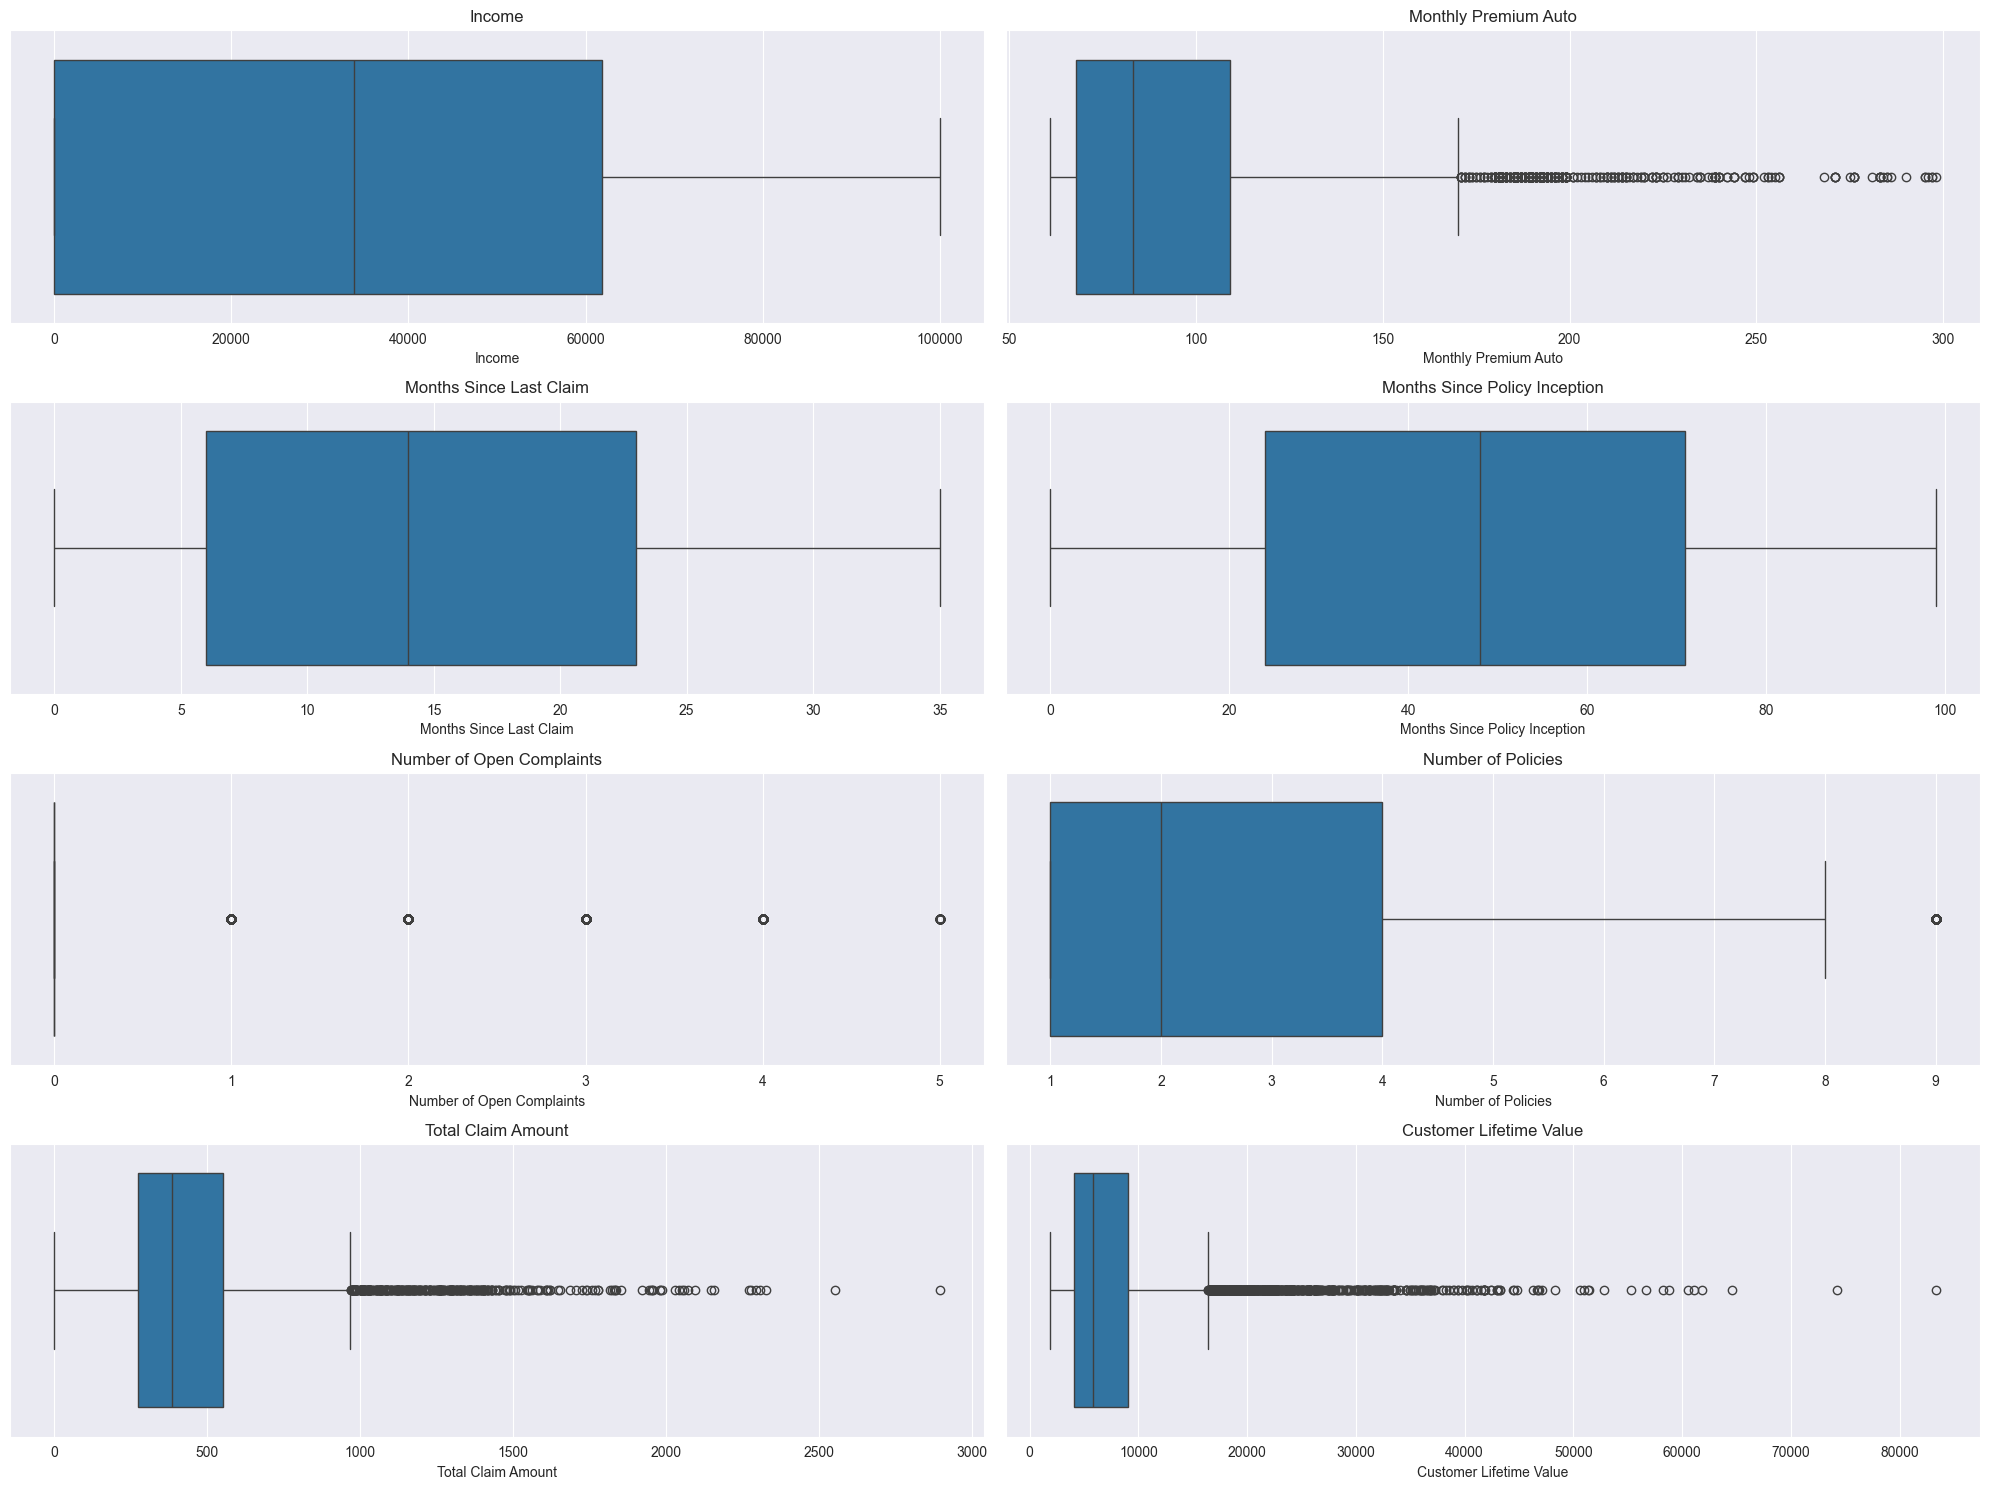

In [356]:
numerical_col = df.select_dtypes(include=['number']).columns
plt.figure(figsize=(20, 15))

for idx, col in enumerate(numerical_col, start=1):
    plt.subplot(4, 2, idx)
    sns.boxplot(x=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

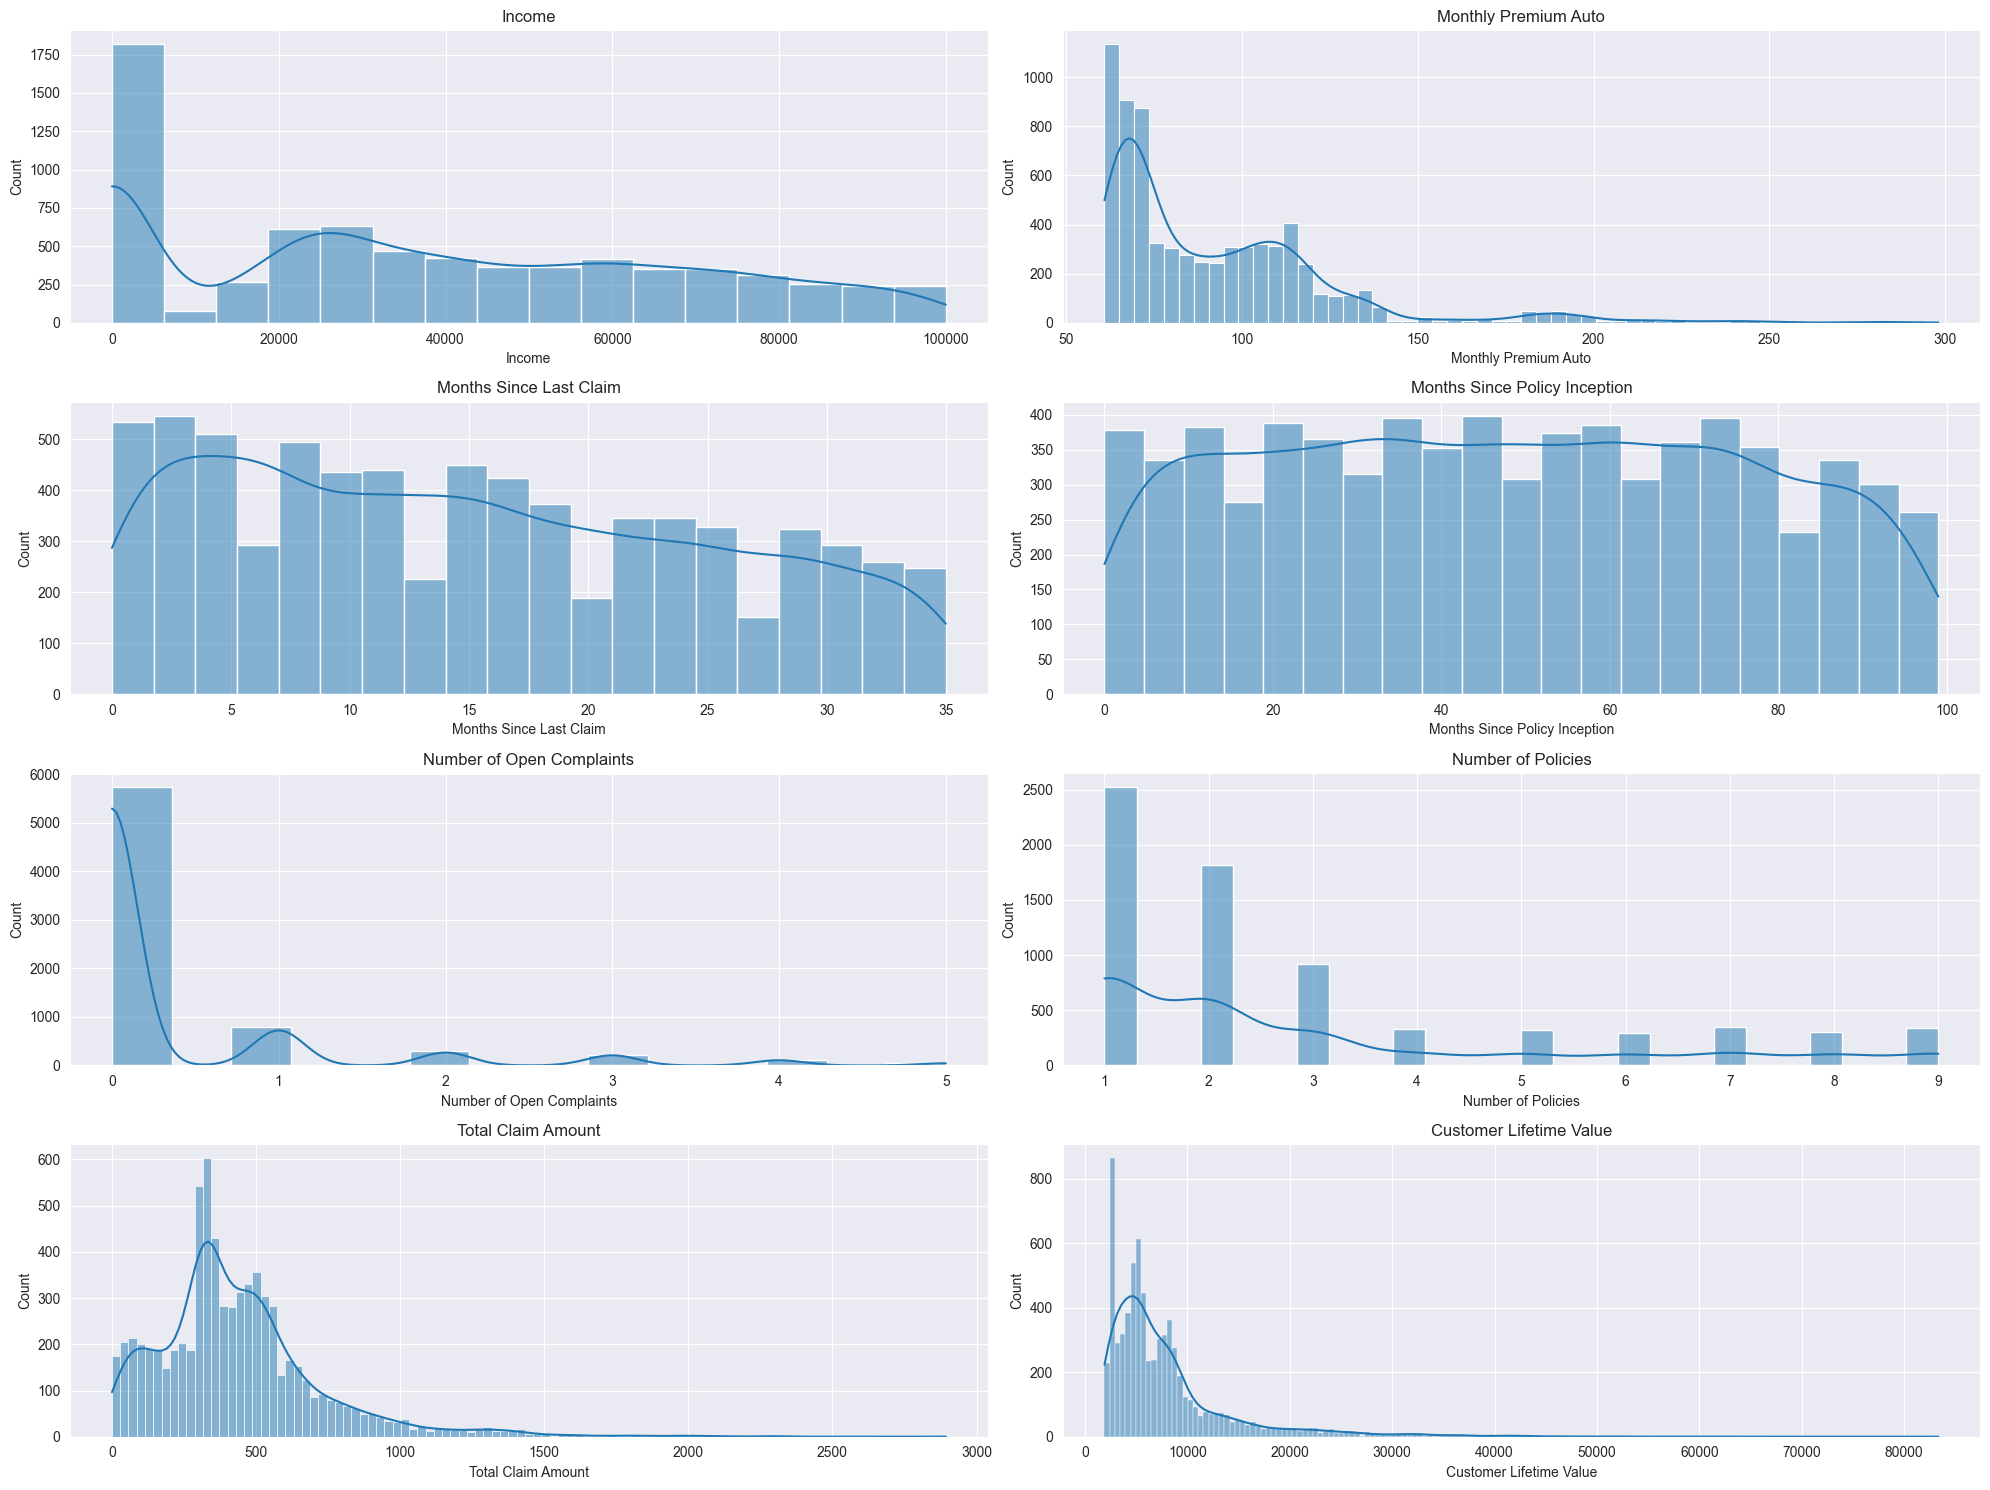

In [357]:
plt.figure(figsize=(20, 15))

for idx, col in enumerate(numerical_col, start=1):
    plt.subplot(4, 2, idx)
    sns.histplot(x=df[col],kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()

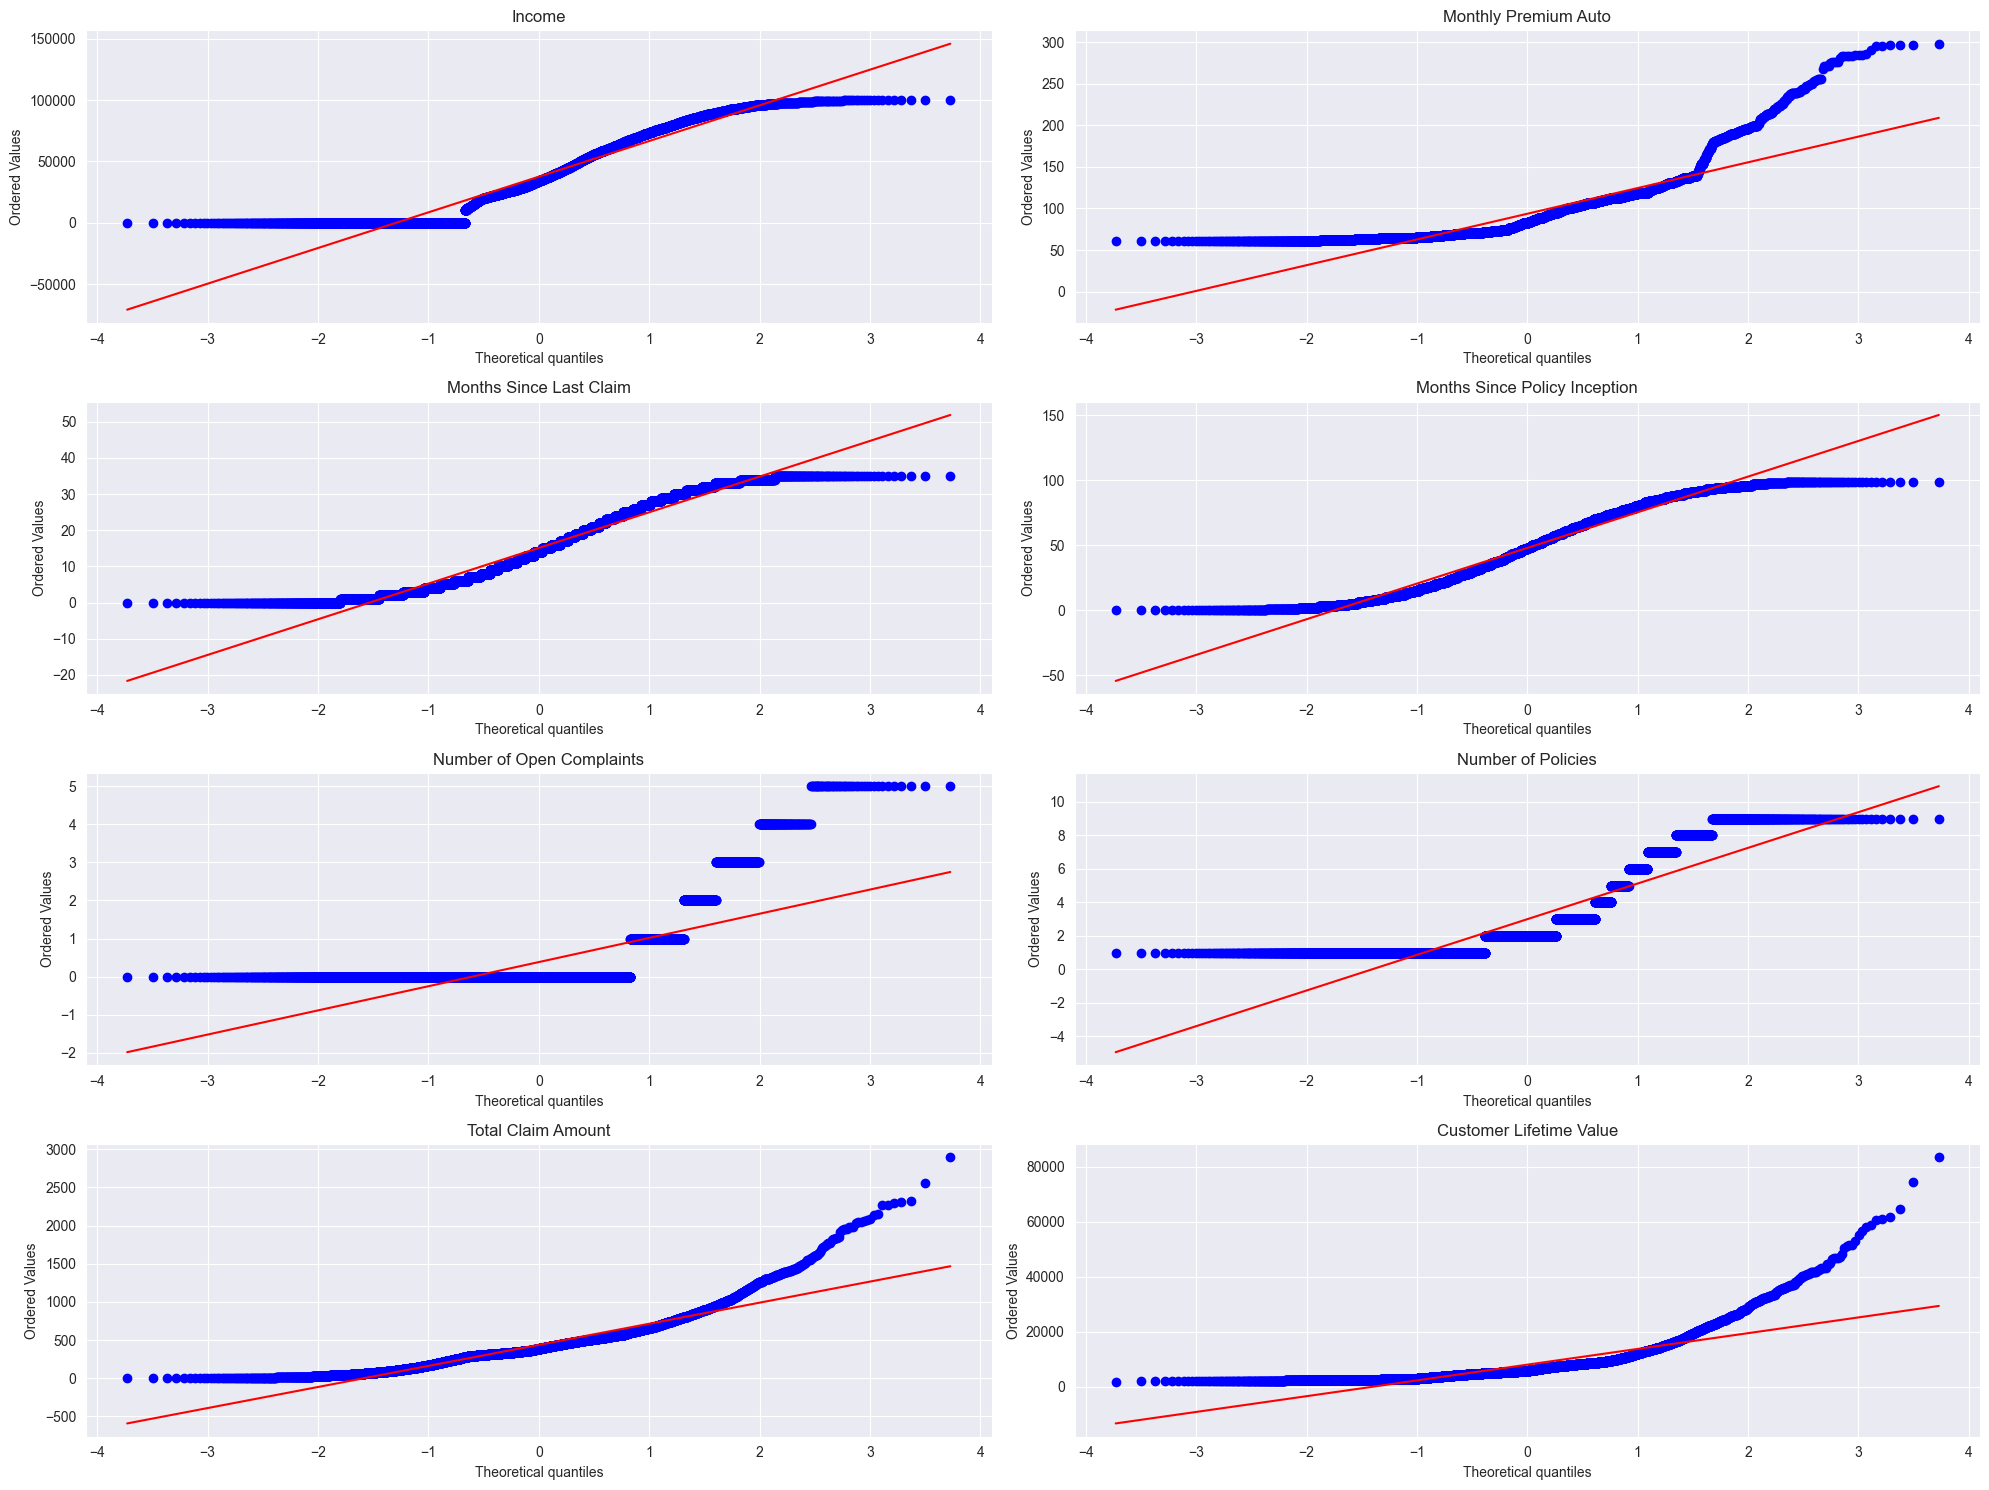

In [358]:
# Set up the matplotlib figure
plt.figure(figsize=(20, 15))

# Create a Q-Q plot for each feature
for idx, col in enumerate(numerical_col, start=1):
    plt.subplot(4, 2, idx)
    stats.probplot(df[col], dist="norm", plot=plt)
    plt.title(col)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


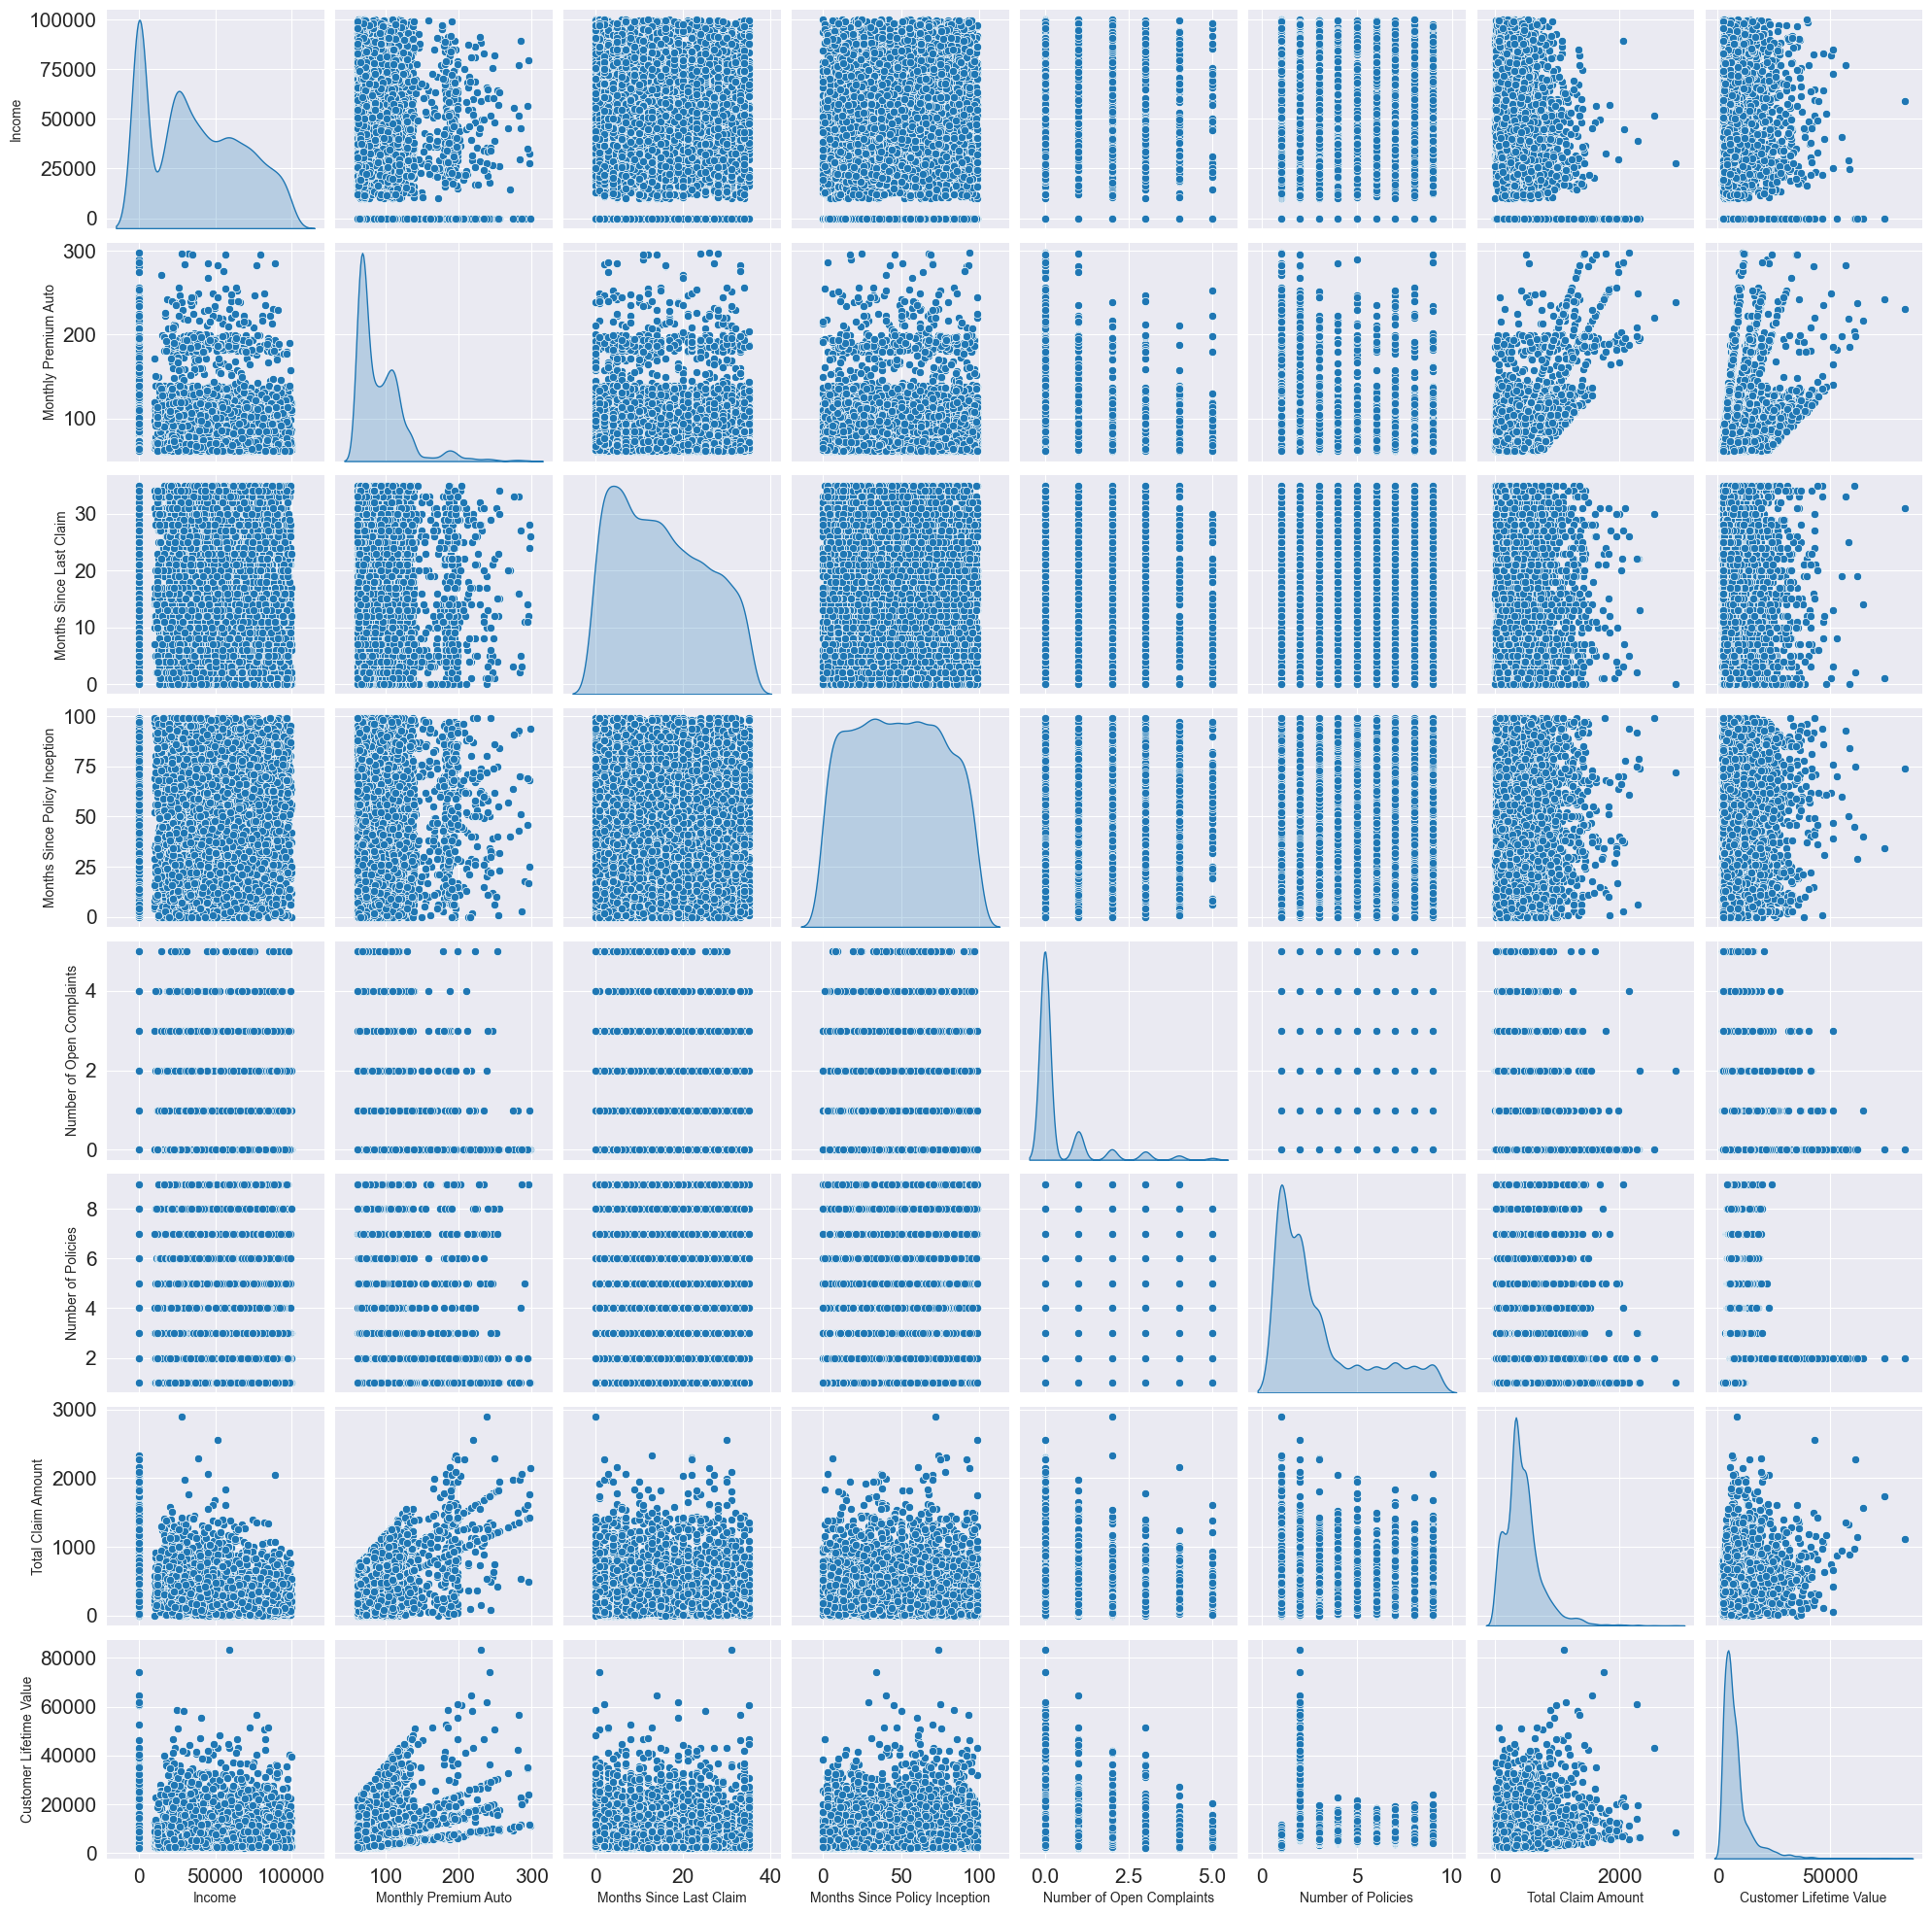

In [359]:
numerical_cols = df.select_dtypes(include='number')

# Create a pairplot with the numerical columns
g = sns.pairplot(numerical_cols, kind='scatter', diag_kind='kde')

# Adjust tick parameters for better readability
for ax in g.axes.flatten():
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)

# Show the plot
plt.show()

In [360]:
num_cor = numerical_cols.corr(method='spearman')

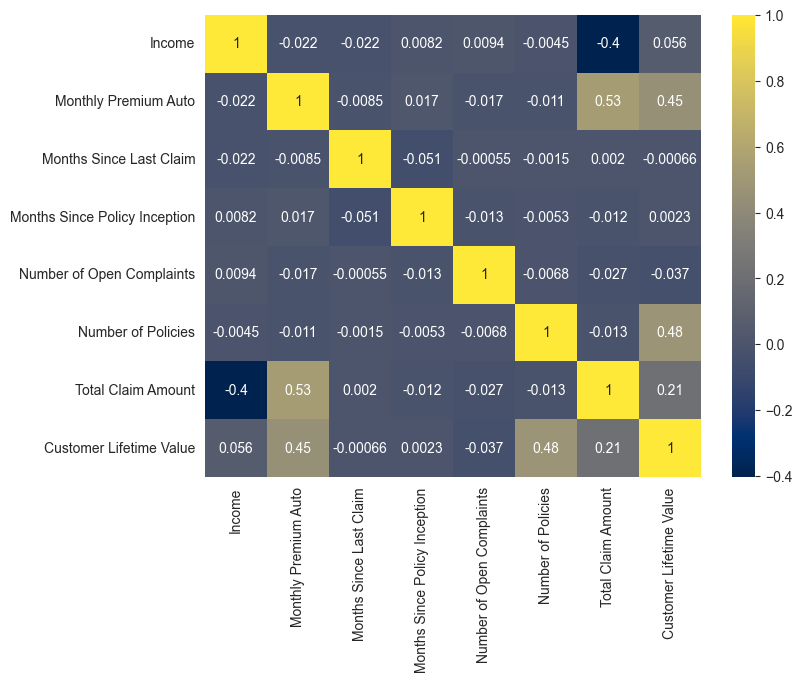

In [361]:
plt.figure(figsize=(8,6))
sns.heatmap(num_cor,annot = True,cmap='cividis')
plt.show()

### Categorical Data

#### Check Cardinality

In [362]:
for col in df.columns:
    if df[col].dtype =="object":
        print(col, ': ', len(df[col].unique()), ' labels')

State :  5  labels
Response :  2  labels
Coverage :  3  labels
Education :  5  labels
EmploymentStatus :  5  labels
Gender :  2  labels
Location Code :  3  labels
Marital Status :  3  labels
Policy Type :  3  labels
Policy :  9  labels
Renew Offer Type :  4  labels
Sales Channel :  4  labels
Vehicle Class :  6  labels
Vehicle Size :  3  labels


based on lalala high cardinality is....

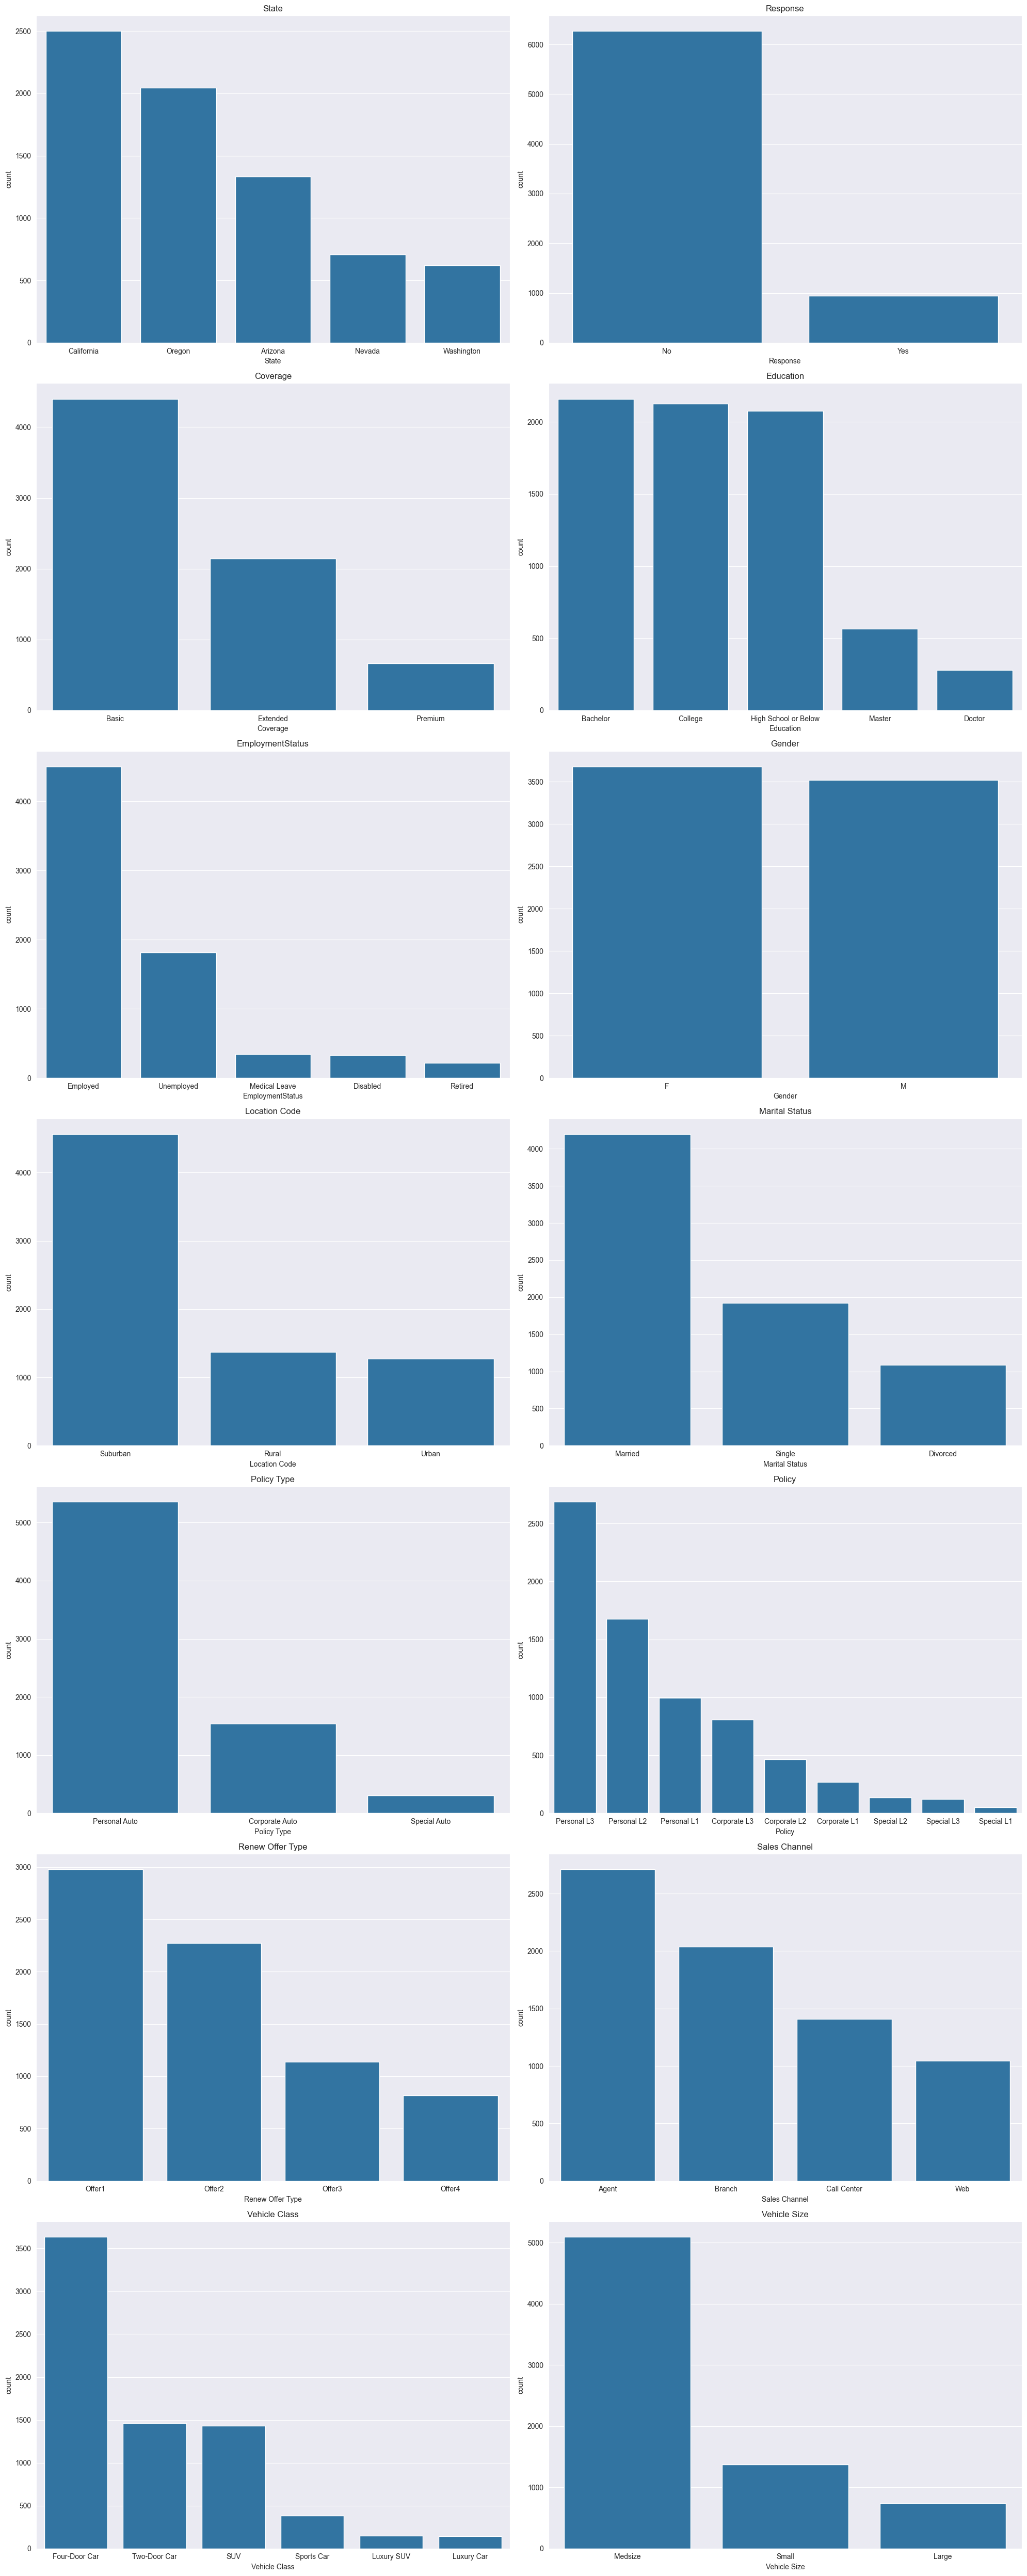

In [363]:
# Select categorical columns
categorical_col = df.select_dtypes(include='object').columns

# Create a figure with appropriate size
plt.figure(figsize=(20, 50))

# Loop through each categorical column and create a subplot
for idx, col in enumerate(categorical_col, start=1):
    plt.subplot(7,2, idx)
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(col)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


## Check Outliers

In [364]:
# Dictionary to store outliers' information
outliers_info = {}

# Dictionary to count outlier occurrences per row
outlier_counts = {}

# List of columns to check for outliers
columns_to_check = ['Customer Lifetime Value', 'Income', 'Monthly Premium Auto',
                    'Months Since Last Claim', 'Months Since Policy Inception',
                    'Number of Open Complaints', 'Number of Policies',
                    'Total Claim Amount']

for column in columns_to_check:
    # Calculate quartiles
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    
    # Calculate IQR and bounds
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers_condition = (df[column] < lower_bound) | (df[column] > upper_bound)
    outliers = df[outliers_condition]

    # Count outliers
    num_outliers = outliers.shape[0]

    # Calculate percentage of outliers
    total_data_points = df[column].shape[0]
    percentage_outliers = (num_outliers / total_data_points) * 100

    # Store information in the dictionary
    outliers_info[column] = {
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'number_of_outliers': num_outliers,  # Count of outliers
        'percentage_of_outliers': percentage_outliers,  # Percentage of outliers
        'outliers_indices': outliers.index.tolist()  # Indices of outliers
    }

    # Update the outlier counts dictionary
    for idx in outliers.index:
        if idx in outlier_counts:
            outlier_counts[idx] += 1
        else:
            outlier_counts[idx] = 1

# Find rows that are outliers in at least 2 columns
rows_to_drop = [idx for idx, count in outlier_counts.items() if count >= 2]

# Summary for outliers_summary
outliers_summary = {key: {'lower_bound': value['lower_bound'], 
                          'upper_bound': value['upper_bound'],
                          'number_of_outliers': value['number_of_outliers'],
                          'percentage_of_outliers': value['percentage_of_outliers']} 
                    for key, value in outliers_info.items()}

# Create DataFrame from 'outliers_summary'
outliers_summary_df = pd.DataFrame.from_dict(outliers_summary, orient='index')

# Display DataFrame as a styled table with all numerical values formatted to two decimal places
styled_table = outliers_summary_df.style.format({
    'lower_bound': '{:.2f}',
    'upper_bound': '{:.2f}',
    'number_of_outliers': '{}',
    'percentage_of_outliers': '{:.2f}%'
})
display(styled_table)

# Drop rows that are outliers in at least 2 columns
df_cleaned = df.drop(index=rows_to_drop)

# Check the shape of the cleaned DataFrame
print(f"Original DataFrame shape: {df.shape}")



Original DataFrame shape: (7204, 23)


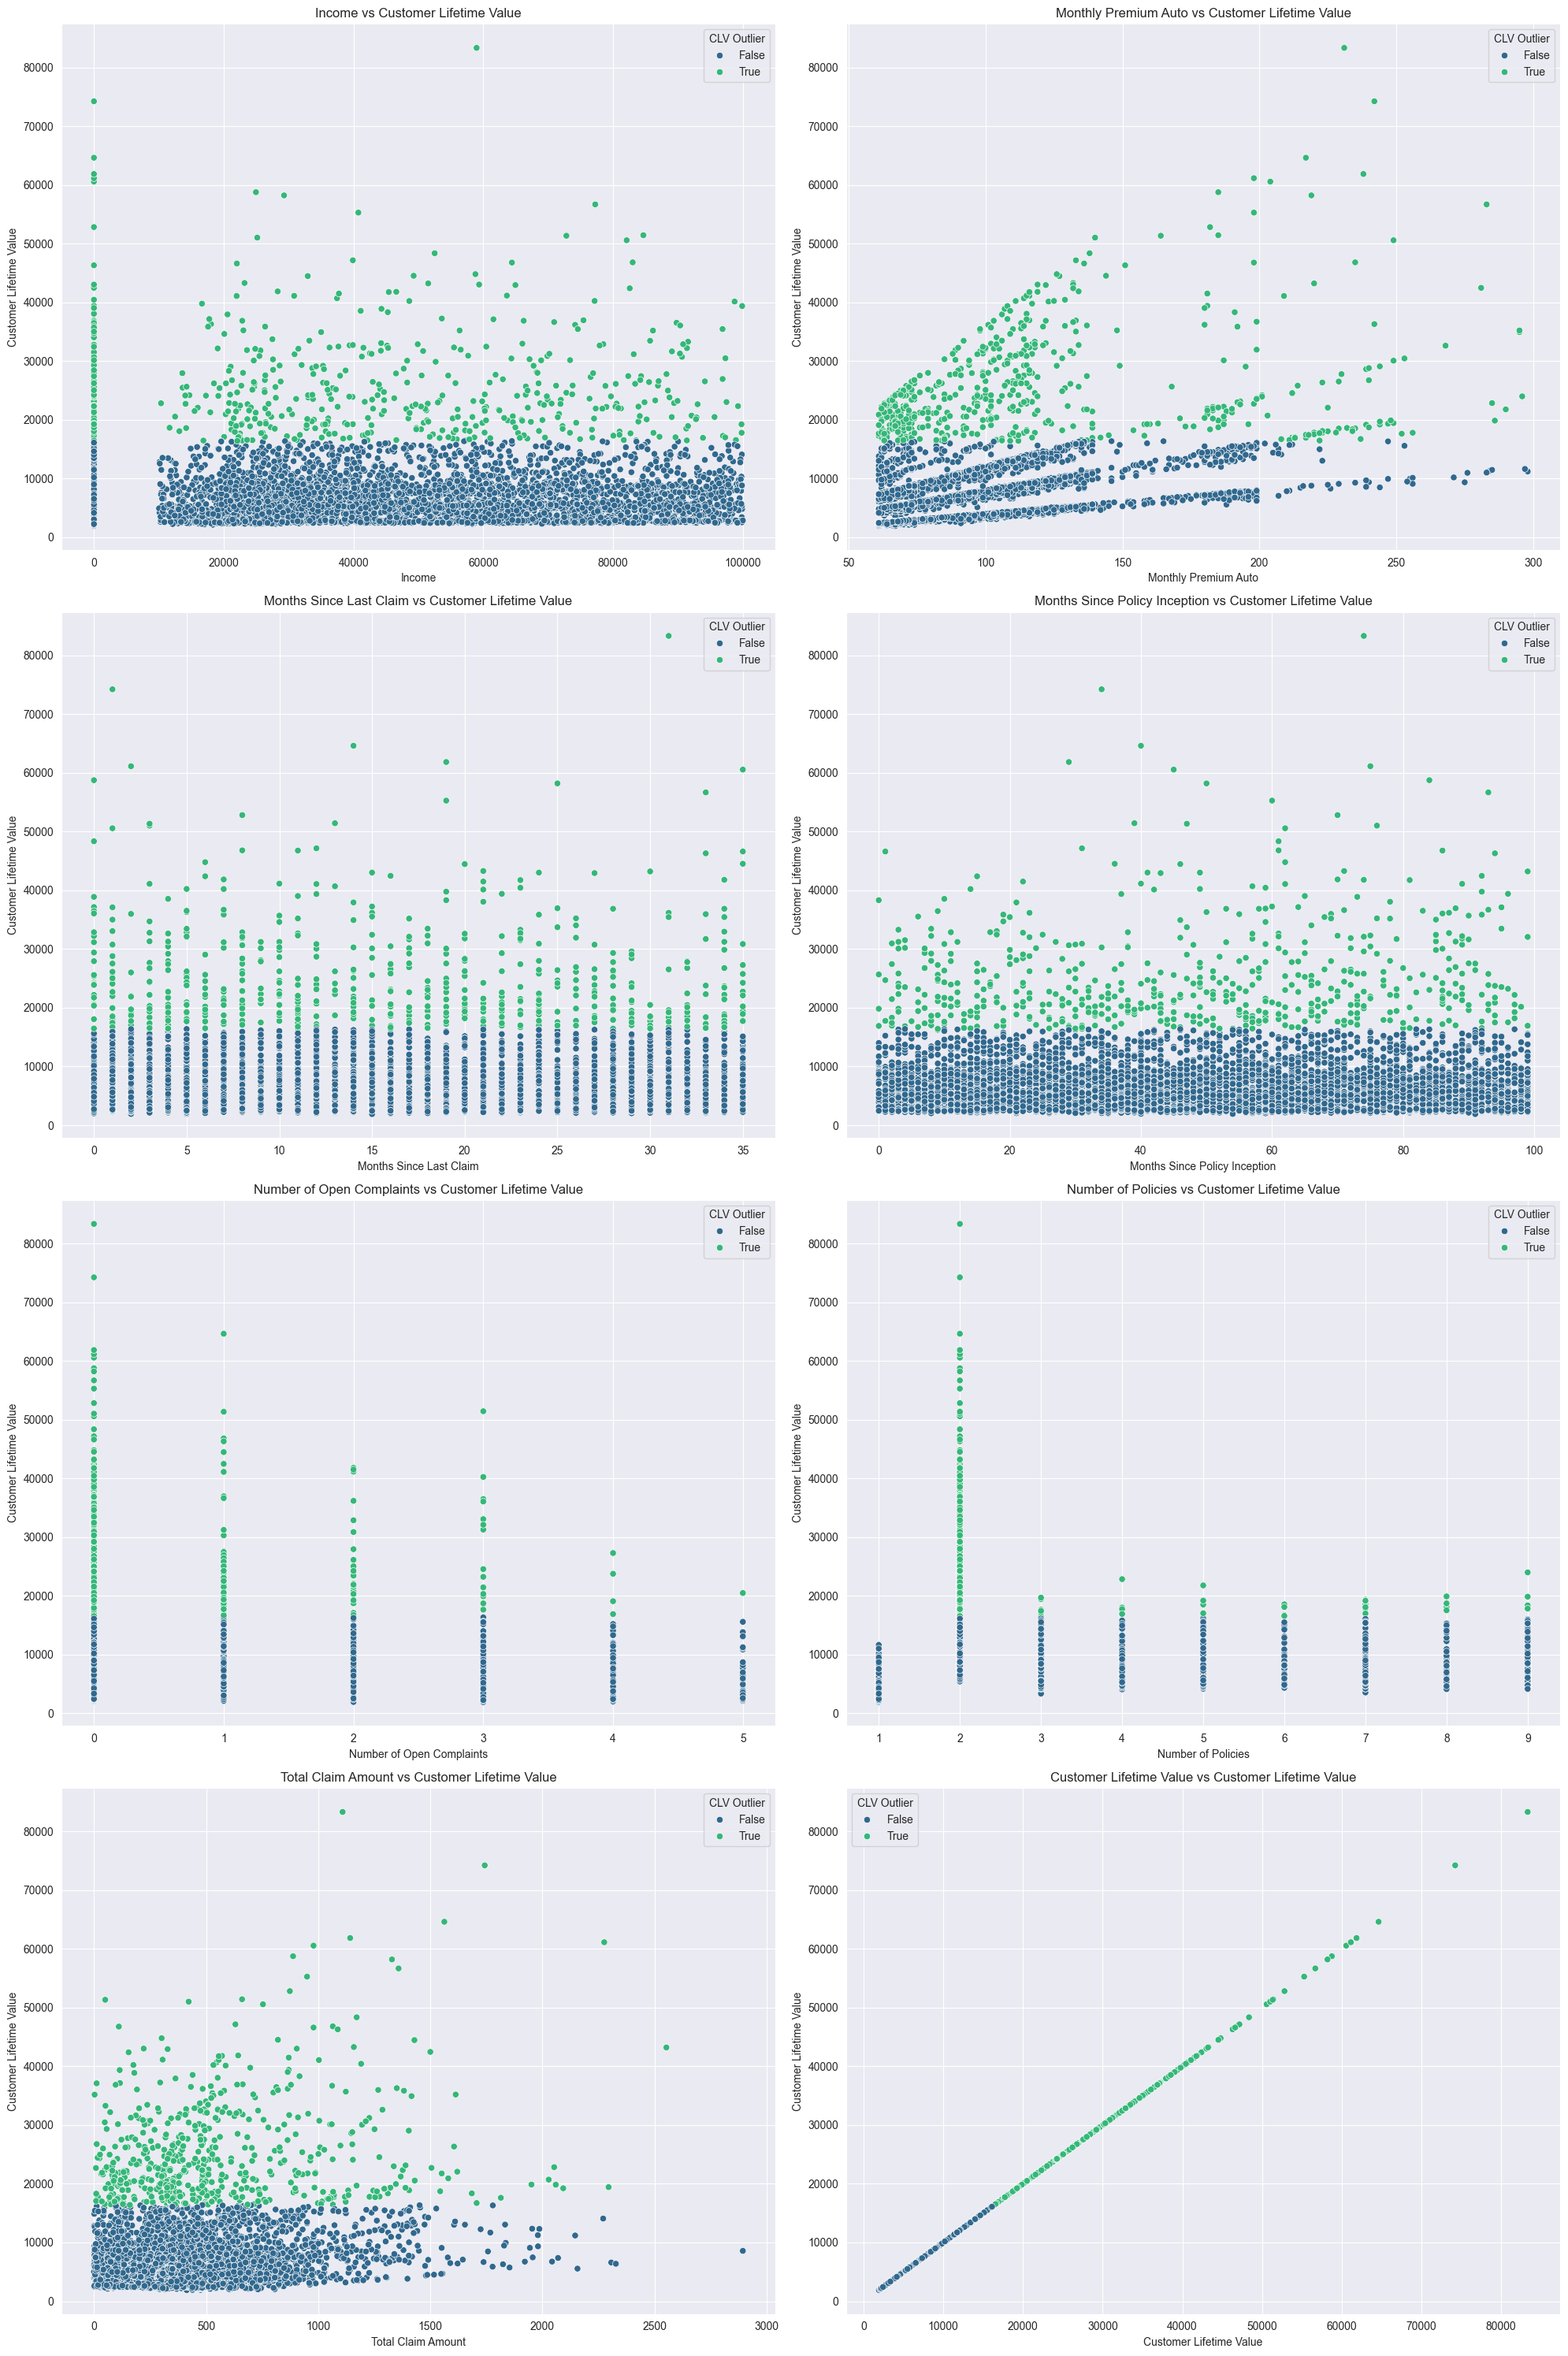

In [365]:
clv_outliers = df.copy()
clv_outliers['CLV Outlier'] = clv_outliers['Customer Lifetime Value'] > 16389.55

plt.figure(figsize=(20, 30))
for idx, feature in enumerate(numerical_cols, start=1):
    plt.subplot(4, 2, idx)
    sns.scatterplot(data=clv_outliers, x=feature, y='Customer Lifetime Value', hue='CLV Outlier', palette='viridis')
    plt.title(f'{feature} vs Customer Lifetime Value')
    plt.xlabel(feature)
    plt.ylabel('Customer Lifetime Value')

plt.tight_layout()
plt.show()

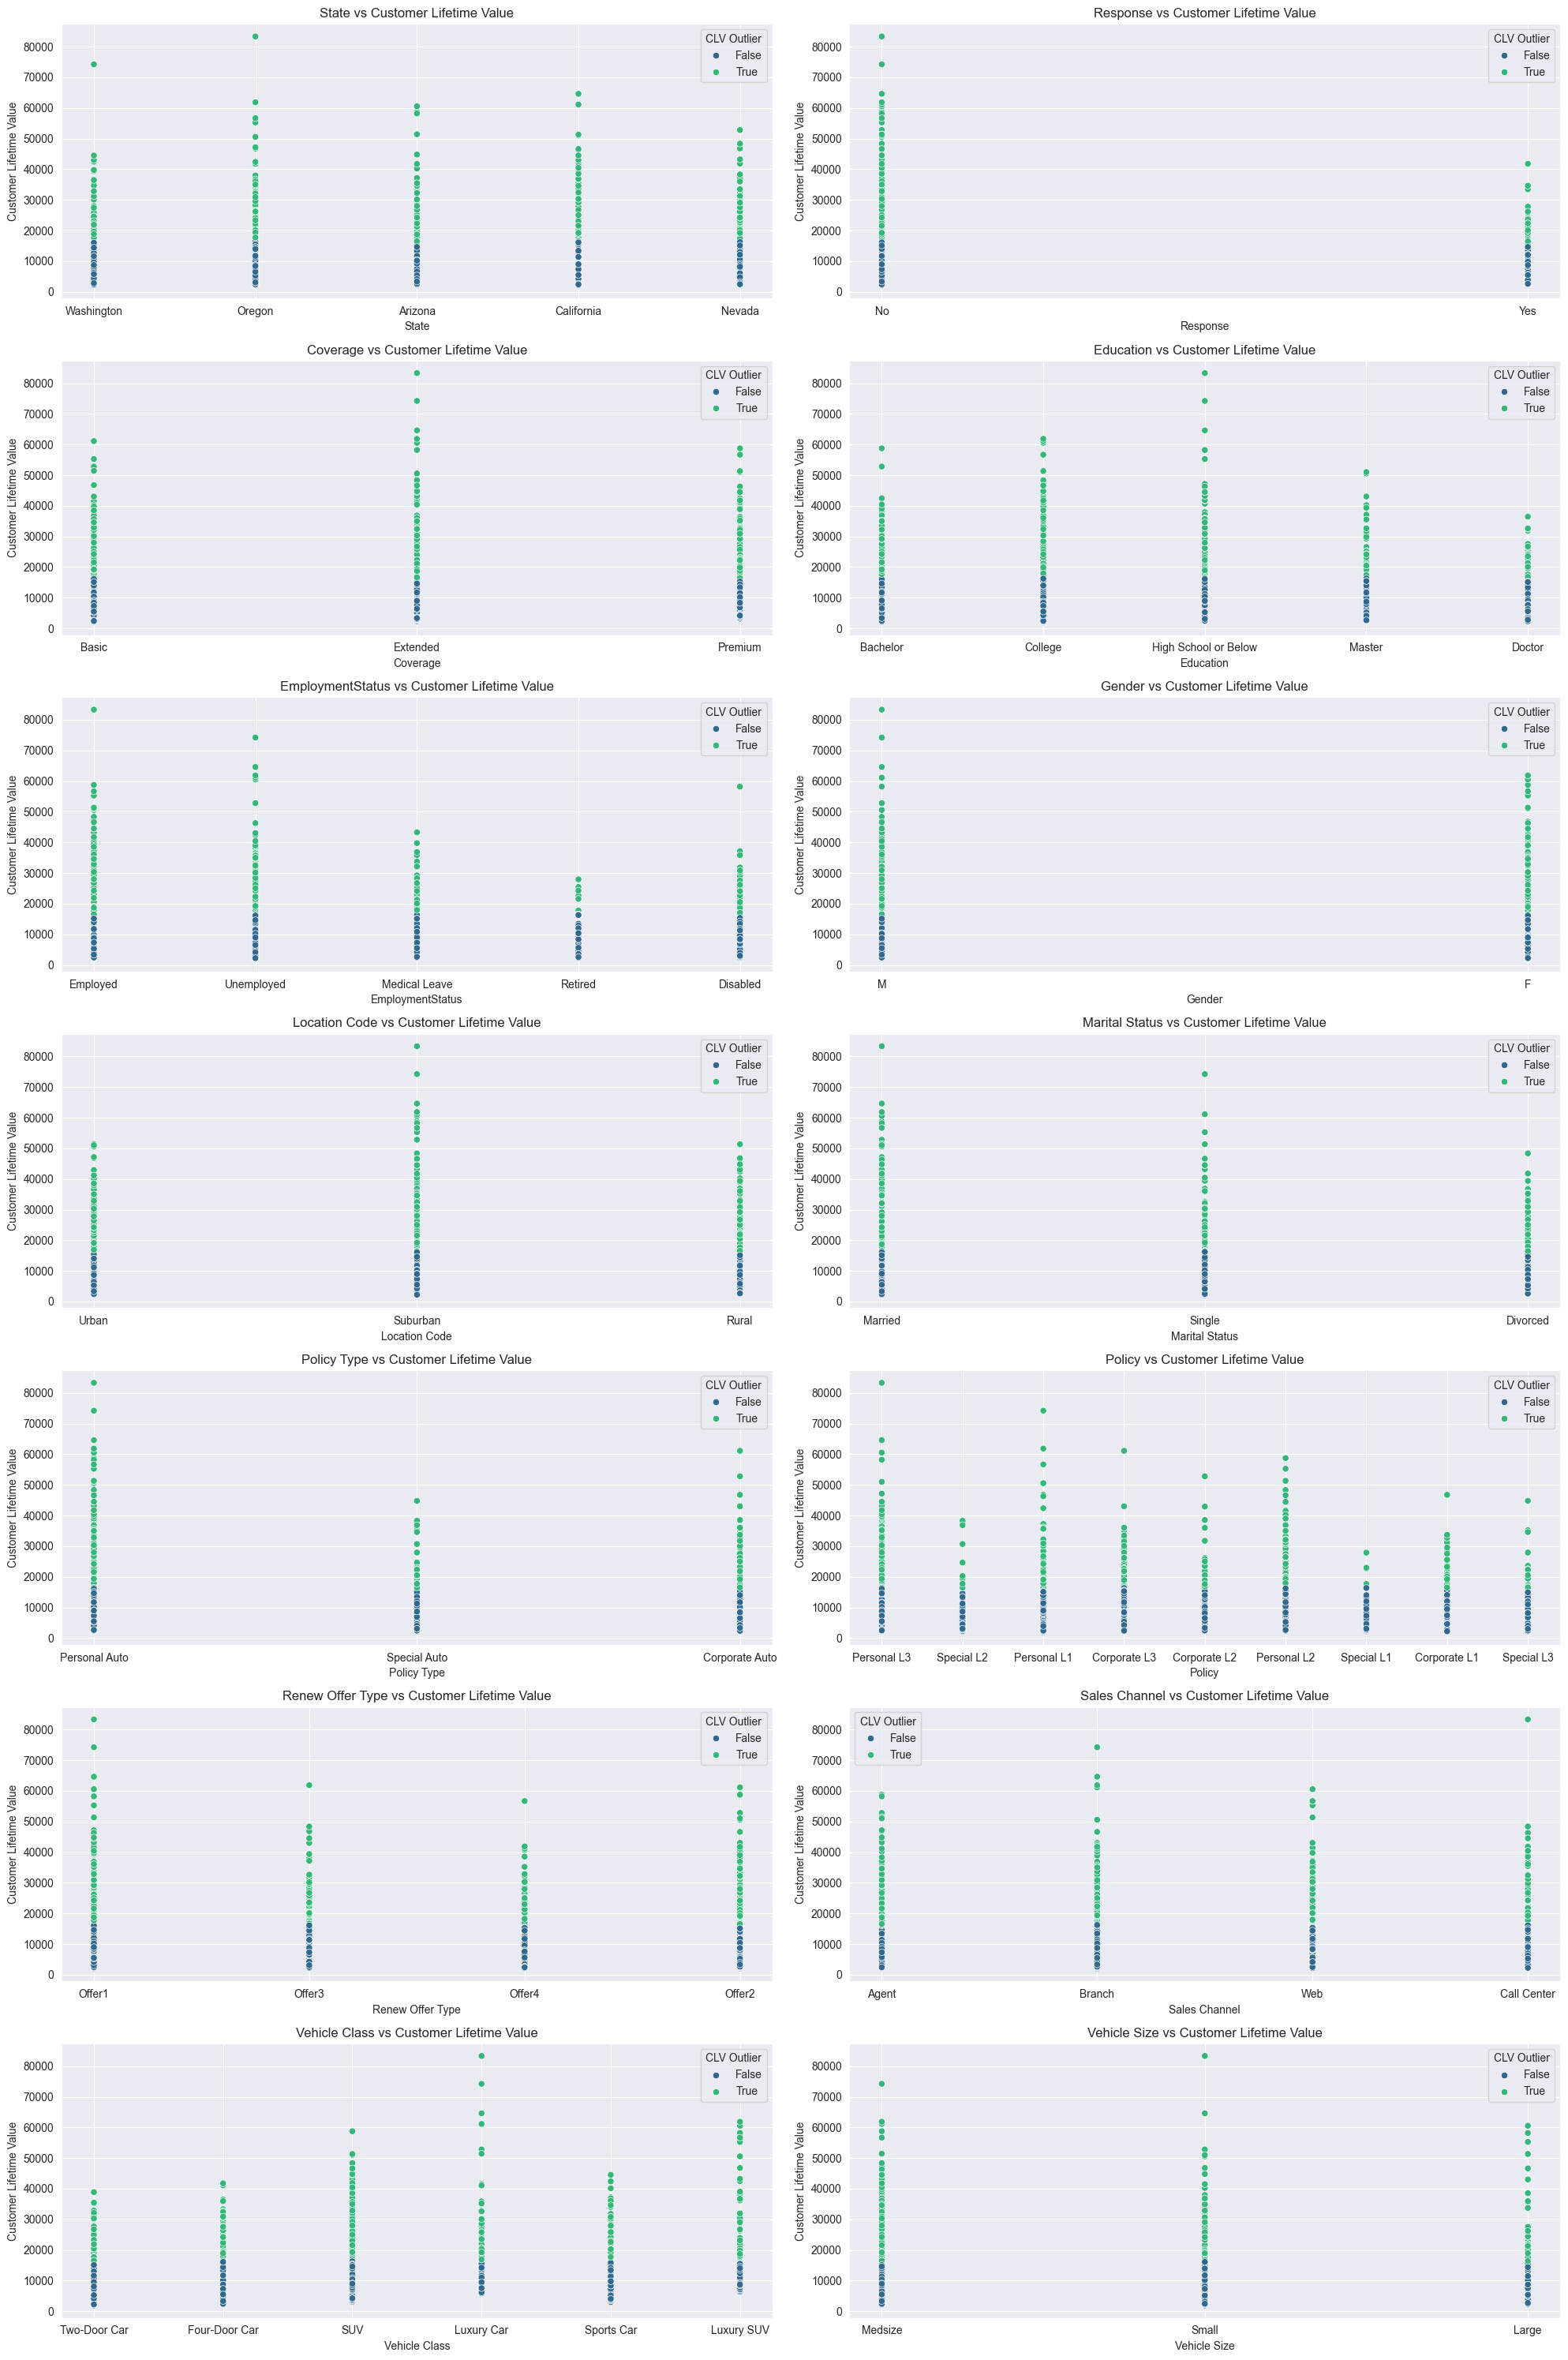

In [366]:
clv_outliers = df.copy()
clv_outliers['CLV Outlier'] = clv_outliers['Customer Lifetime Value'] > 16389.55

plt.figure(figsize=(20, 30))
for idx, feature in enumerate(categorical_col, start=1):
    plt.subplot(7, 2, idx)
    sns.scatterplot(data=clv_outliers, x=feature, y='Customer Lifetime Value', hue='CLV Outlier', palette='viridis')
    plt.title(f'{feature} vs Customer Lifetime Value')
    plt.xlabel(feature)
    plt.ylabel('Customer Lifetime Value')

plt.tight_layout()
plt.show()

we would remove outliers that have more than 1 slice in another column

### Remove Outliers

In [367]:
# Dictionary to store outliers' information
outliers_info = {}

# Dictionary to count outlier occurrences per row
outlier_counts = {}

# List of columns to check for outliers
columns_to_check = ['Customer Lifetime Value', 'Income', 'Monthly Premium Auto',
                    'Months Since Last Claim', 'Months Since Policy Inception',
                    'Number of Open Complaints', 'Number of Policies',
                    'Total Claim Amount']

for column in columns_to_check:
    # Calculate quartiles
    Q1 = df_cleaned[column].quantile(0.25)
    Q3 = df_cleaned[column].quantile(0.75)
    
    # Calculate IQR and bounds
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers_condition = (df_cleaned[column] < lower_bound) | (df_cleaned[column] > upper_bound)
    outliers = df_cleaned[outliers_condition]

    # Count outliers
    num_outliers = outliers.shape[0]

    # Calculate percentage of outliers
    total_data_points = df_cleaned[column].shape[0]
    percentage_outliers = (num_outliers / total_data_points) * 100

    # Store information in the dictionary
    outliers_info[column] = {
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'number_of_outliers': num_outliers,  # Count of outliers
        'percentage_of_outliers': percentage_outliers,  # Percentage of outliers
        'outliers_indices': outliers.index.tolist()  # Indices of outliers
    }

    # Update the outlier counts dictionary
    for idx in outliers.index:
        if idx in outlier_counts:
            outlier_counts[idx] += 1
        else:
            outlier_counts[idx] = 1

# Find rows that are outliers in at least 2 columns
rows_to_drop = [idx for idx, count in outlier_counts.items() if count >= 2]

# Summary for outliers_summary
outliers_summary = {key: {'lower_bound': value['lower_bound'], 
                          'upper_bound': value['upper_bound'],
                          'number_of_outliers': value['number_of_outliers'],
                          'percentage_of_outliers': value['percentage_of_outliers']} 
                    for key, value in outliers_info.items()}

# Create DataFrame from 'outliers_summary'
outliers_summary_df = pd.DataFrame.from_dict(outliers_summary, orient='index')

# Display DataFrame as a styled table with all numerical values formatted to two decimal places
styled_table = outliers_summary_df.style.format({
    'lower_bound': '{:.2f}',
    'upper_bound': '{:.2f}',
    'number_of_outliers': '{}',
    'percentage_of_outliers': '{:.2f}%'
})
display(styled_table)

print(f"Cleaned DataFrame shape: {df_cleaned.shape}")

Cleaned DataFrame shape: (6721, 23)


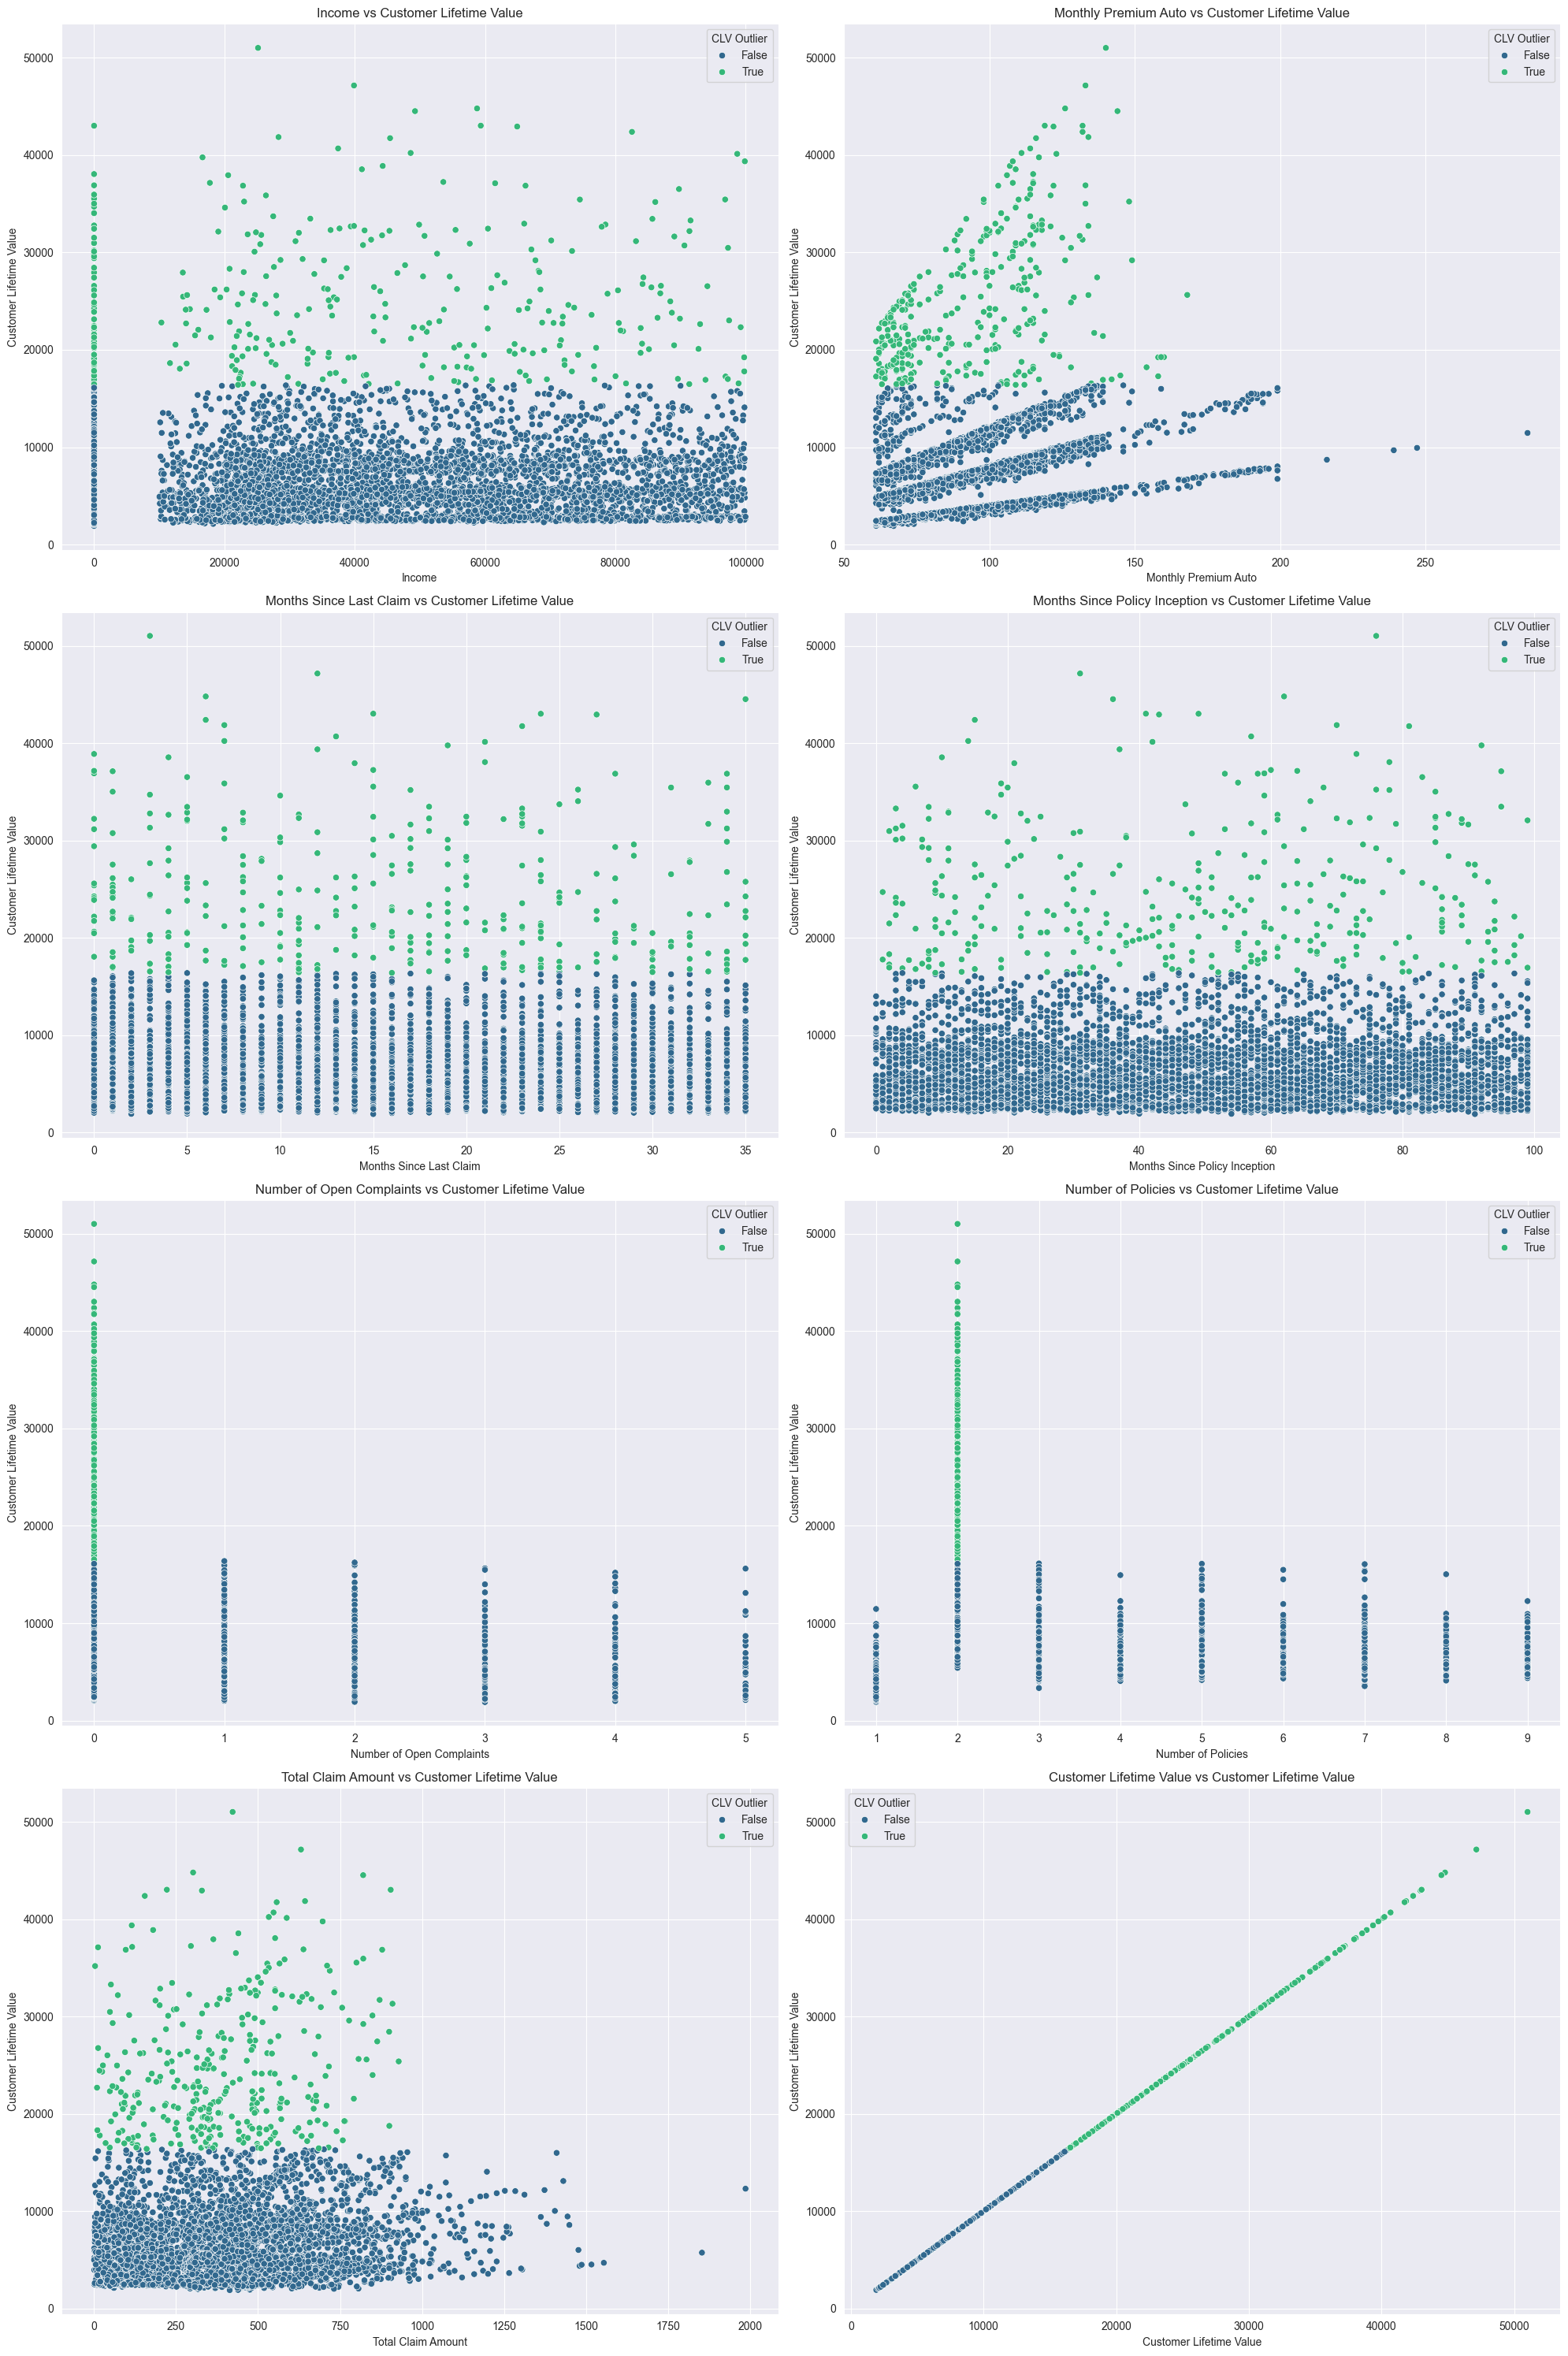

In [368]:
clv_outliers = df_cleaned.copy()
clv_outliers['CLV Outlier'] = clv_outliers['Customer Lifetime Value'] > 16389.55

plt.figure(figsize=(20, 30))
for idx, feature in enumerate(numerical_cols, start=1):
    plt.subplot(4, 2, idx)
    sns.scatterplot(data=clv_outliers, x=feature, y='Customer Lifetime Value', hue='CLV Outlier', palette='viridis')
    plt.title(f'{feature} vs Customer Lifetime Value')
    plt.xlabel(feature)
    plt.ylabel('Customer Lifetime Value')

plt.tight_layout()
plt.show()

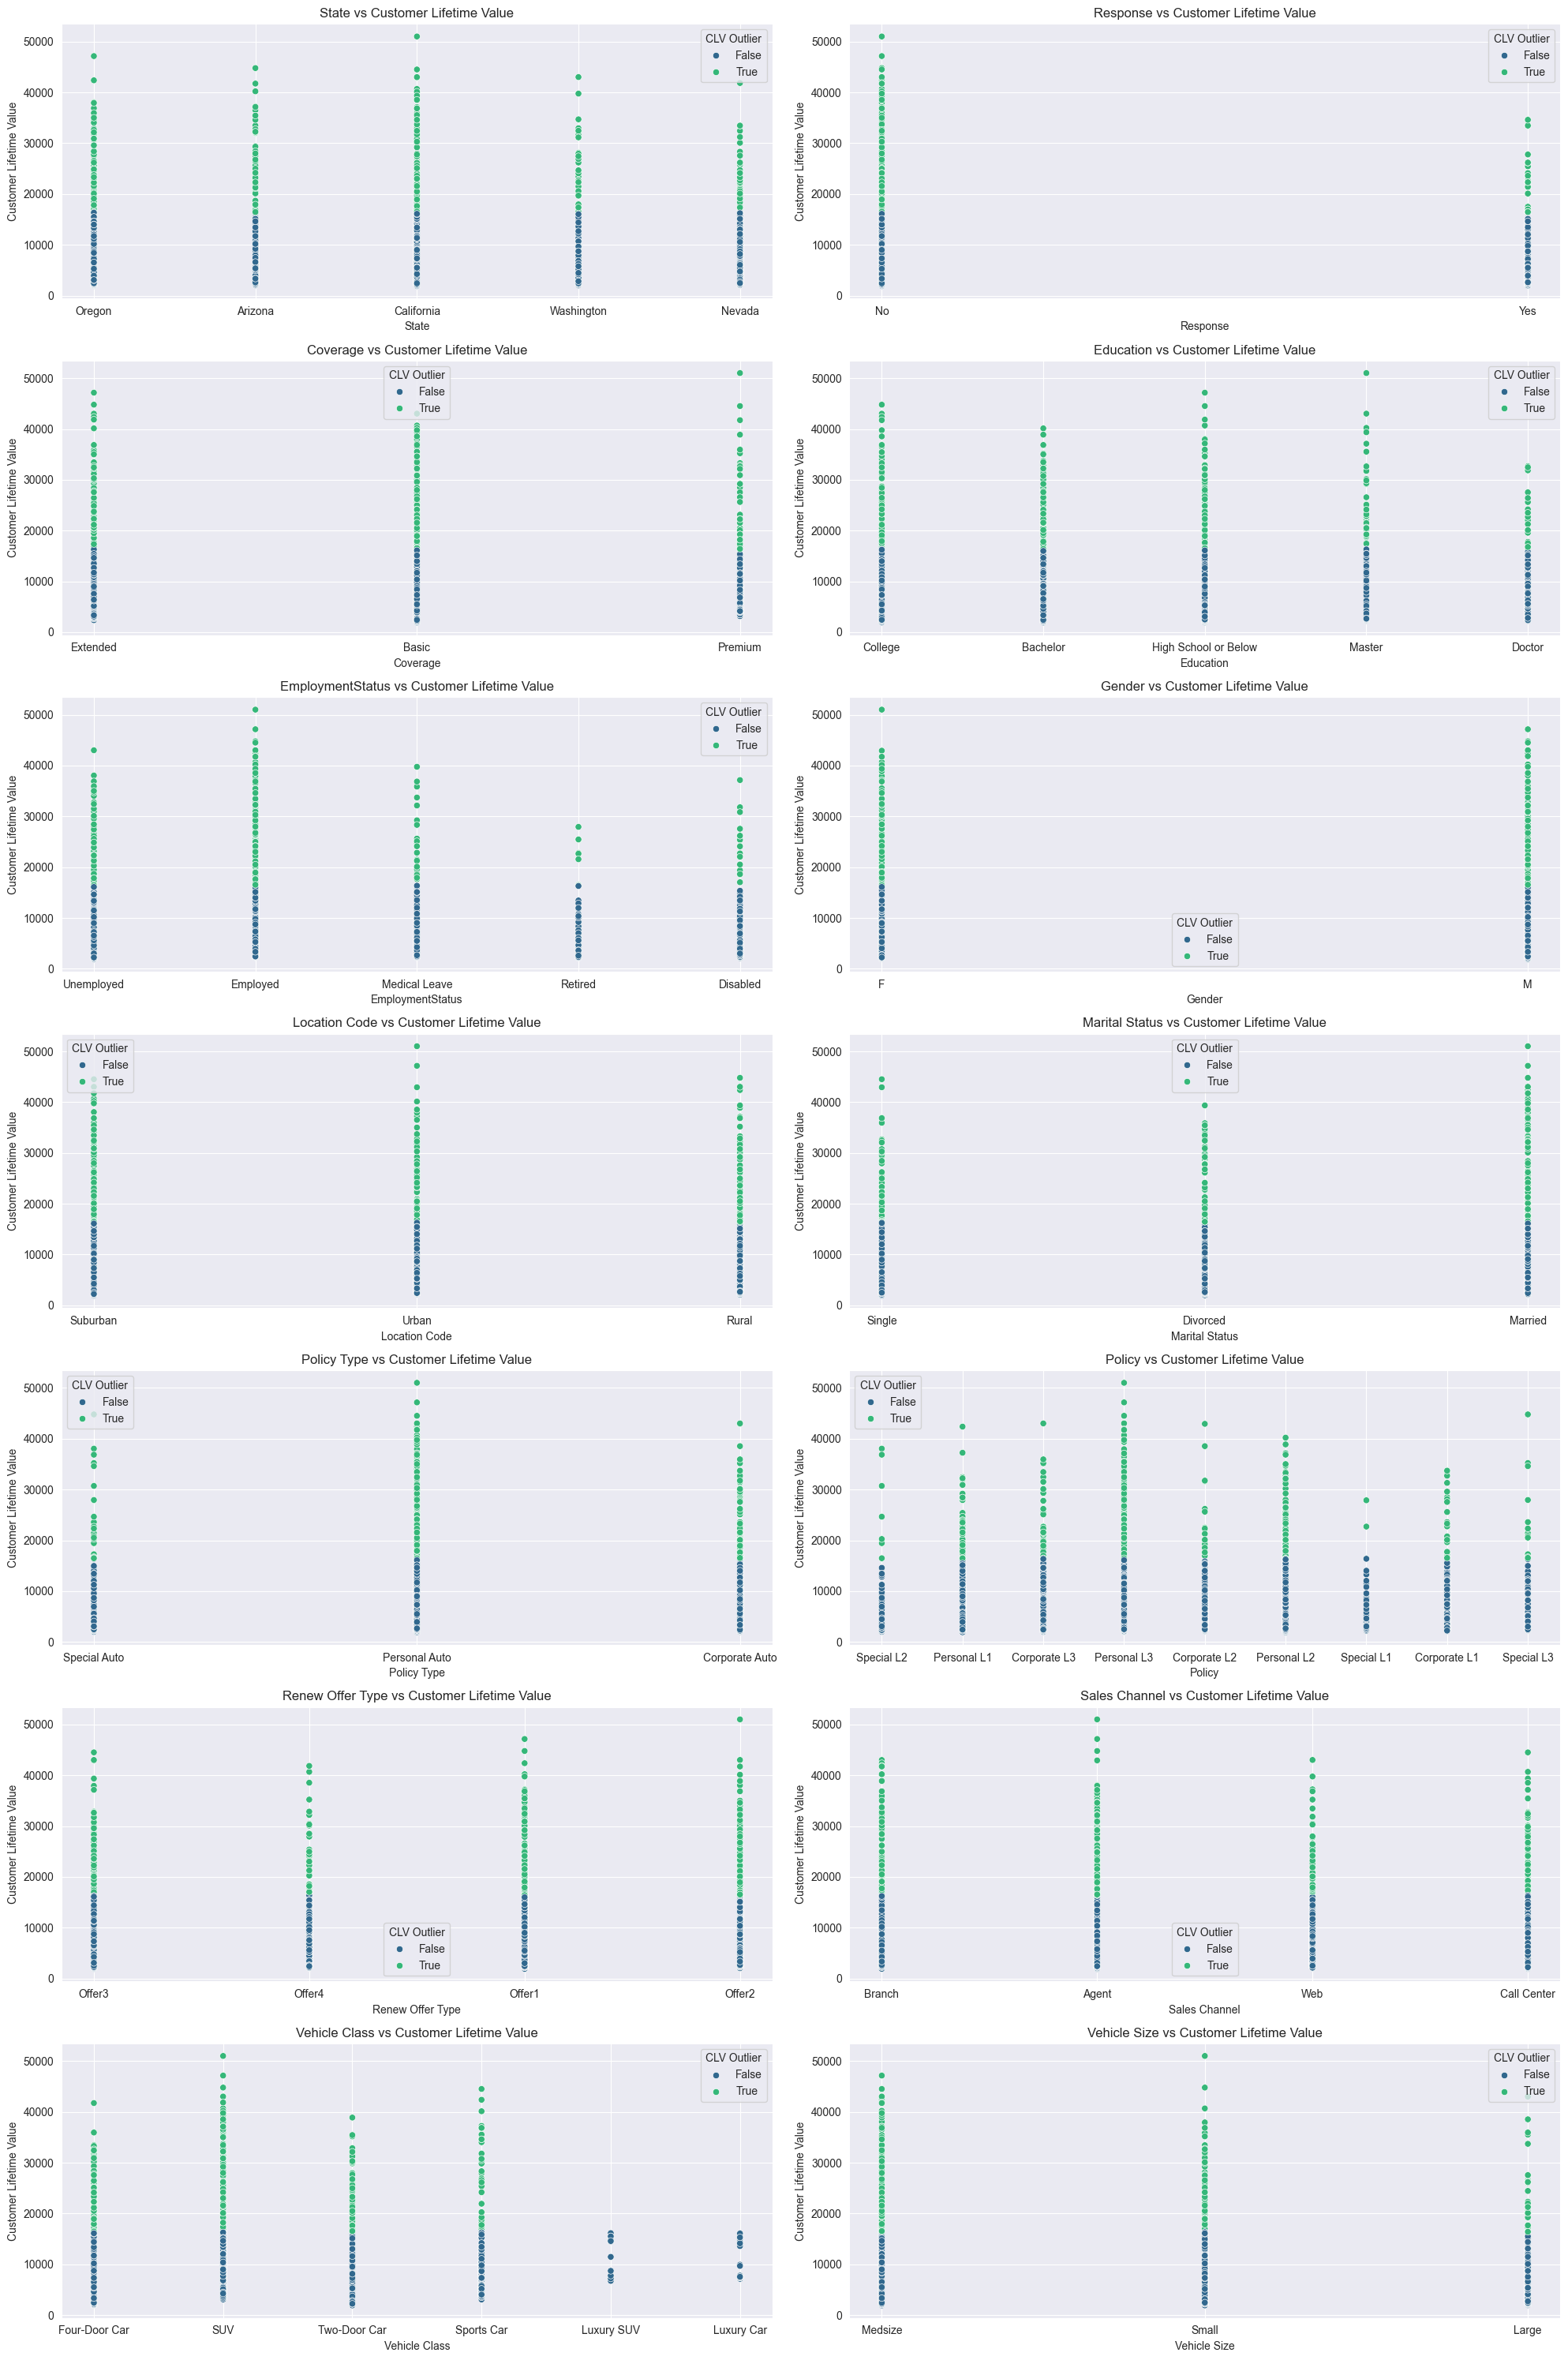

In [369]:
clv_outliers = df_cleaned.copy()
clv_outliers['CLV Outlier'] = clv_outliers['Customer Lifetime Value'] > 16389.55

plt.figure(figsize=(20, 30))
for idx, feature in enumerate(categorical_col, start=1):
    plt.subplot(7, 2, idx)
    sns.scatterplot(data=clv_outliers, x=feature, y='Customer Lifetime Value', hue='CLV Outlier', palette='viridis')
    plt.title(f'{feature} vs Customer Lifetime Value')
    plt.xlabel(feature)
    plt.ylabel('Customer Lifetime Value')

plt.tight_layout()
plt.show()

# EXPLORATORY DATA ANALYSIS

State CLV

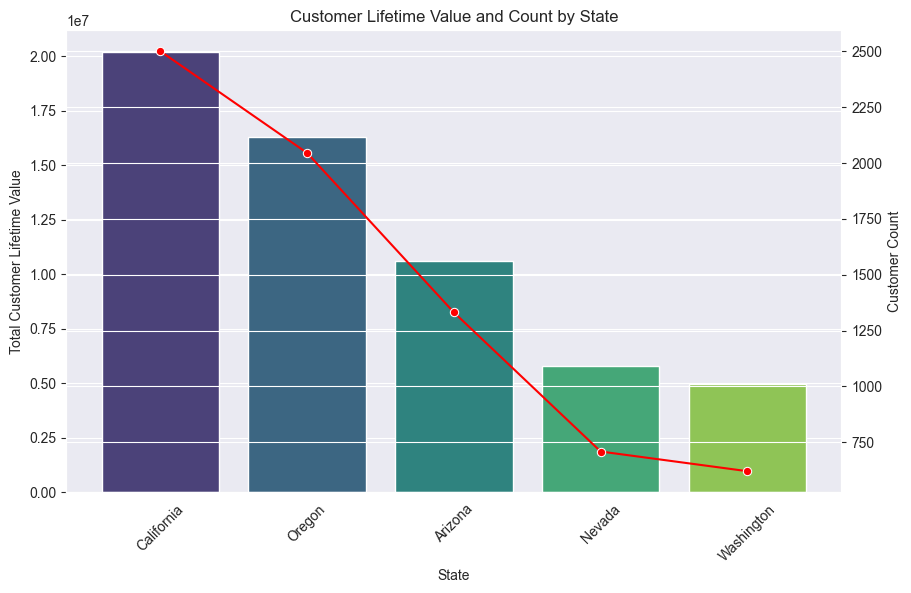

In [370]:
# Calculate total CLV and customer count per state
clv_per_state = df.groupby('State')['Customer Lifetime Value'].sum().reset_index()
count_per_state = df.groupby('State').size().reset_index(name='Customer Count')

# Merge the two dataframes on State
state_data = pd.merge(clv_per_state, count_per_state, on='State')

# Sort the data by CLV
state_data = state_data.sort_values(by='Customer Lifetime Value', ascending=False)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# First axis: Total CLV
sns.barplot(x='State', y='Customer Lifetime Value', data=state_data, palette='viridis', ax=ax1)
ax1.set_xlabel('State')
ax1.set_ylabel('Total Customer Lifetime Value')
ax1.set_title('Customer Lifetime Value and Count by State')
ax1.tick_params(axis='x', rotation=45)

# Second axis: Customer Count
ax2 = ax1.twinx()
sns.lineplot(x='State', y='Customer Count', data=state_data, color='red', marker='o', ax=ax2)
ax2.set_ylabel('Customer Count')

plt.show()


Coverage CLV

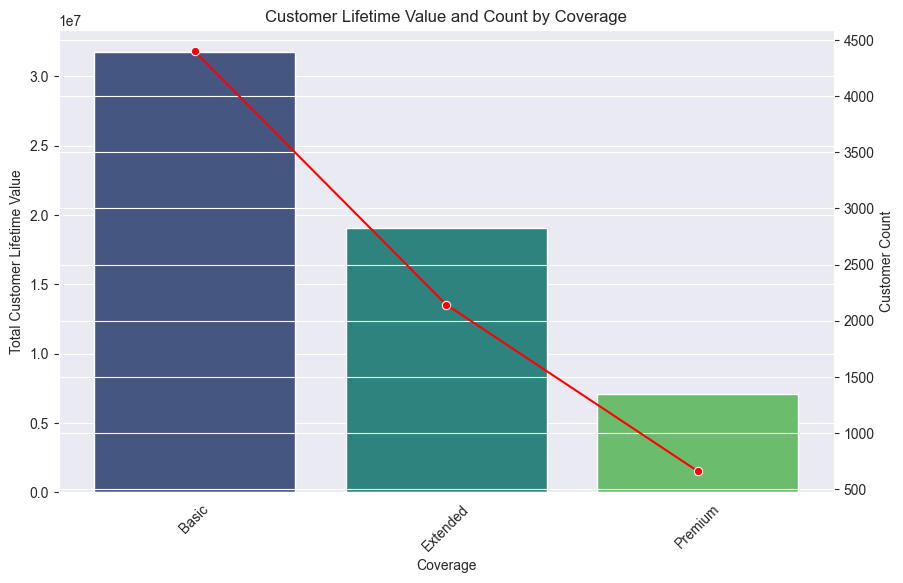

In [371]:
# Calculate total CLV and customer count per Coverage
clv_per_coverage = df.groupby('Coverage')['Customer Lifetime Value'].sum().reset_index()
count_per_coverage = df.groupby('Coverage').size().reset_index(name='Customer Count')

# Merge the two dataframes on Coverage
coverage_data = pd.merge(clv_per_coverage, count_per_coverage, on='Coverage')

# Sort the data by CLV
coverage_data = coverage_data.sort_values(by='Customer Lifetime Value', ascending=False)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# First axis: Total CLV
sns.barplot(x='Coverage', y='Customer Lifetime Value', data=coverage_data, palette='viridis', ax=ax1)
ax1.set_xlabel('Coverage')
ax1.set_ylabel('Total Customer Lifetime Value')
ax1.set_title('Customer Lifetime Value and Count by Coverage')
ax1.tick_params(axis='x', rotation=45)

# Second axis: Customer Count
ax2 = ax1.twinx()
sns.lineplot(x='Coverage', y='Customer Count', data=coverage_data, color='red', marker='o', ax=ax2)
ax2.set_ylabel('Customer Count')

plt.show()


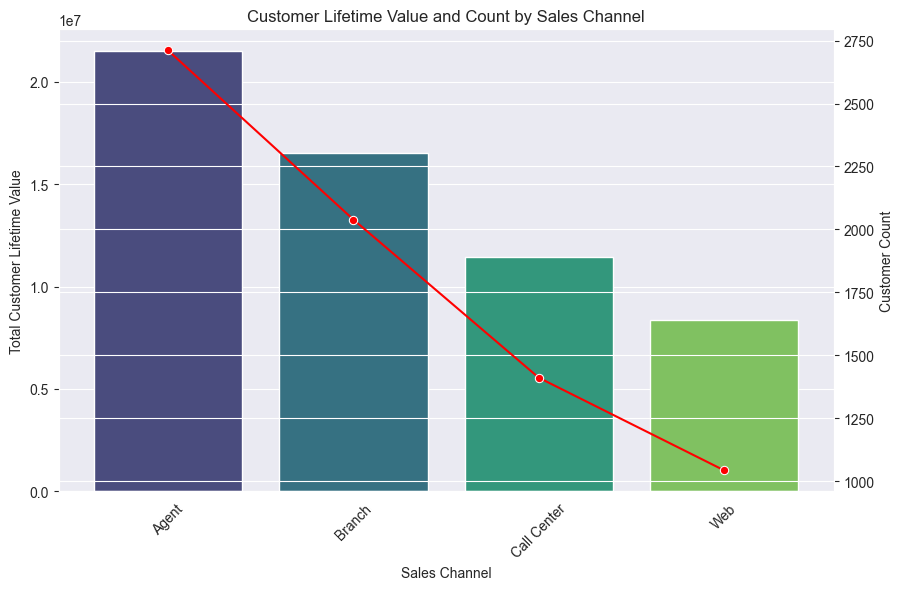

In [372]:

# Calculate total CLV and customer count per Sales Channel
clv_per_channel = df.groupby('Sales Channel')['Customer Lifetime Value'].sum().reset_index()
count_per_channel = df.groupby('Sales Channel').size().reset_index(name='Customer Count')

# Merge the two dataframes on Sales Channel
channel_data = pd.merge(clv_per_channel, count_per_channel, on='Sales Channel')

# Sort the data by CLV
channel_data = channel_data.sort_values(by='Customer Lifetime Value', ascending=False)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# First axis: Total CLV
sns.barplot(x='Sales Channel', y='Customer Lifetime Value', data=channel_data, palette='viridis', ax=ax1)
ax1.set_xlabel('Sales Channel')
ax1.set_ylabel('Total Customer Lifetime Value')
ax1.set_title('Customer Lifetime Value and Count by Sales Channel')
ax1.tick_params(axis='x', rotation=45)

# Second axis: Customer Count
ax2 = ax1.twinx()
sns.lineplot(x='Sales Channel', y='Customer Count', data=channel_data, color='red', marker='o', ax=ax2)
ax2.set_ylabel('Customer Count')

plt.show()


# FEATURE ENGINEERING

## ADD RANDOM STATE

In [373]:
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)


## ADD FEATURES

In [382]:
df['EOY'] = pd.to_datetime('2011-12-31')
df['EOY DAYS'] = (df['EOY'] - df['Effective To Date']).dt.days
df.drop(columns=['Effective To Date','EOY'])

State Response  Coverage             Education EmploymentStatus  \
0     Washington       No     Basic              Bachelor         Employed   
1         Oregon       No  Extended               College       Unemployed   
2        Arizona       No     Basic               College         Employed   
3     California       No     Basic              Bachelor         Employed   
4     Washington       No     Basic              Bachelor         Employed   
...          ...      ...       ...                   ...              ...   
7302  California       No     Basic               College         Employed   
7303  California      Yes     Basic               College    Medical Leave   
7304  California       No  Extended  High School or Below       Unemployed   
7305     Arizona      Yes  Extended              Bachelor       Unemployed   
7306     Arizona       No  Extended              Bachelor         Employed   

     Gender  Income Location Code Marital Status  Monthly Premium Auto  \
0         M   51144         Urban        Married                    61   
1         F       0      Suburban         Single                    79   
2         M   81097      Suburban       Divorced                    74   
3         F   72264         Urban        Married                    64   
4         F   54737      Suburban         Single                    66   
...     ...     ...           ...            ...                   ...   
7302      F   87957      Suburban       Divorced                    61   
7303      M   22520      Suburban        Married                    73   
7304      F       0      Suburban         Single                   129   
7305      F       0      Suburban       Divorced                   139   
7306      M   78092         Urban        Married                    84   

      Months Since Last Claim  Months Since Policy Inception  \
0                          28                             32   
1                          30                             25   
2                           7                             67   
3                           2                             66   
4                           3                             86   
...                       ...                            ...   
7302                       31                             63   
7303                       17                             64   
7304                       13                              4   
7305                        5                             56   
7306                       34                             13   

      Number of Open Complaints  Number of Policies     Policy Type  \
0                             1                   9   Personal Auto   
1                             0                   1    Special Auto   
2                             0                   1   Personal Auto   
3                             0                   9  Corporate Auto   
4                             0                   1   Personal Auto   
...                         ...                 ...             ...   
7302                          0                   2   Personal Auto   
7303                          0                   3   Personal Auto   
7304                          0                   7   Personal Auto   
7305                          0                   2   Personal Auto   
7306                          0                   1  Corporate Auto   

            Policy Renew Offer Type Sales Channel  Total Claim Amount  \
0      Personal L3           Offer1         Agent          223.305224   
1       Special L2           Offer3        Branch          568.800000   
2      Personal L1           Offer4         Agent          355.200000   
3     Corporate L3           Offer3           Web          272.649844   
4      Personal L3           Offer3           Web          391.970334   
...            ...              ...           ...                 ...   
7302   Personal L3           Offer3         Agent   

## DATA SPLITTING

In [376]:
X = df.drop(columns='Customer Lifetime Value')
y = df['Customer Lifetime Value']

# split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = random_seed
)

X_train.shape, X_test.shape

((5763, 24), (1441, 24))

## SCALER

In [377]:
scaler = RobustScaler()

## TRANSFORM

In [ ]:
nominal_features = ['State','Response','EmploymentStatus', 'Gender','Location Code','Marital Status',
                    'Policy Type','Policy','Renew Offer Type','Sales Channel','Vehicle Class','Vehicle Size']

ordinal_features = ['Education', 'Coverage']
edu_order = ['High School or Below', 'College', 'Bachelor', 'Master', 'Doctor']
coverage_orde = ['Basic', 'Extended', 'Premium']

numerical_features = ['Income', 'Monthly Premium Auto', 'Months Since Last Claim',
                      'Months Since Policy Inception', 'Number of Open Complaints',
                      'Number of Policies', 'Total Claim Amount','Effective To Date',
                      'Year','Month','Day']


In [378]:
filtered_df = df[df.duplicated(subset=['Coverage', 'Number of Policies', 'Policy Type', 'Policy', 'Monthly Premium Auto'], keep=False)]

# Sort by Number of Policies
sorted_filtered_df = filtered_df.sort_values(by='Customer Lifetime Value')

# Display the sorted DataFram
sorted_filtered_df

State Response  Coverage             Education Effective To Date  \
3682  California       No     Basic              Bachelor        2011-02-26   
6231  California       No     Basic               College        2011-02-15   
1032      Oregon       No     Basic  High School or Below        2011-07-02   
4537  California      Yes     Basic               College        2011-02-22   
2227  California      Yes     Basic               College        2011-02-22   
...          ...      ...       ...                   ...               ...   
6013  California       No  Extended               College        2011-06-02   
878       Oregon       No     Basic  High School or Below        2011-01-02   
1288      Oregon       No  Extended  High School or Below        2011-10-02   
1568      Oregon       No  Extended                Master        2011-02-28   
4343  Washington       No  Extended  High School or Below        2011-01-26   

     EmploymentStatus Gender  Income Location Code Marital Status  \
3682       Unemployed      M       0      Suburban         Single   
6231       Unemployed      M       0      Suburban         Single   
1032       Unemployed      M       0      Suburban         Single   
4537       Unemployed      F       0      Suburban       Divorced   
2227       Unemployed      F       0      Suburban       Divorced   
...               ...    ...     ...           ...            ...   
6013         Employed      M   22022      Suburban         Single   
878          Employed      F   64403         Rural         Single   
1288         Employed      M   39891         Urban        Married   
1568         Employed      M   82081         Urban        Married   
4343       Unemployed      M       0      Suburban         Single   

      Monthly Premium Auto  Months Since Last Claim  \
3682                    67                       15   
6231                    61                        2   
1032                    66                        5   
4537                    66                       16   
2227                    66                       16   
...                    ...                      ...   
6013                   136                       35   
878                    198                       11   
1288                   133                       12   
1568                   249                        1   
4343                   242                        1   

      Months Since Policy Inception  Number of Open Complaints  \
3682                             91                          3   
6231                             54                          2   
1032                             40                          3   
4537                             35                          4   
2227                             35                          4   
...                             ...                        ...   
6013                              1                          0   
878                              86                          0   
1288                             31                          0   
1568                             62                          0   
4343                             34                          0   

      Number of Policies     Policy Type        Policy Renew Offer Type  \
3682                   1   Personal Auto   Personal L2           Offer1   
6231                   1   Personal Auto   Personal L1           Offer1   
1032                   1   Personal Auto   Personal L3           Offer3   
4537                   1   Personal Auto   Personal L3           Offer1   
2227                   1  Corporate Auto  Corporate L3           Offer1   
...                  ...             ...           ...              ...   
6013                   2   Personal Auto   Personal L2           Offer2   
878                    2  Corporate Auto  Corporate L1           Offer1   
1288                   2   Personal Auto   Personal L3           Offer1   
1568                   2   Pe